## Set up

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import lightning.pytorch as pl
import torch
import pickle

from datetime import datetime, timedelta
from sklearn.tree import DecisionTreeRegressor, plot_tree

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

np.random.seed(42)

In [2]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

## Import the data

In [6]:
online_retail_df = pd.read_json('../../dataset/online_retail_data/online_retail.json')
online_retail_df

,Description,Date,UnitsSold,RevenuePounds,AveragePricePerUnitPounds
0,12 pencils small tube red spotty,2009-12-01,45,29.90,0.66
1,12 pencils small tube red spotty,2009-12-02,87,61.75,0.71
2,12 pencils small tube red spotty,2009-12-03,34,23.40,0.69
3,12 pencils small tube red spotty,2009-12-04,84,55.25,0.66
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.65
...,...,...,...,...,...
104933,wood black board ant white finish,2011-12-05,23,177.13,7.70
104934,wood black board ant white finish,2011-12-06,4,31.80,7.95
104935,wood black board ant white finish,2011-12-07,70,484.50,6.92
104936,wood black board ant white finish,2011-12-08,226,1142.34,5.05


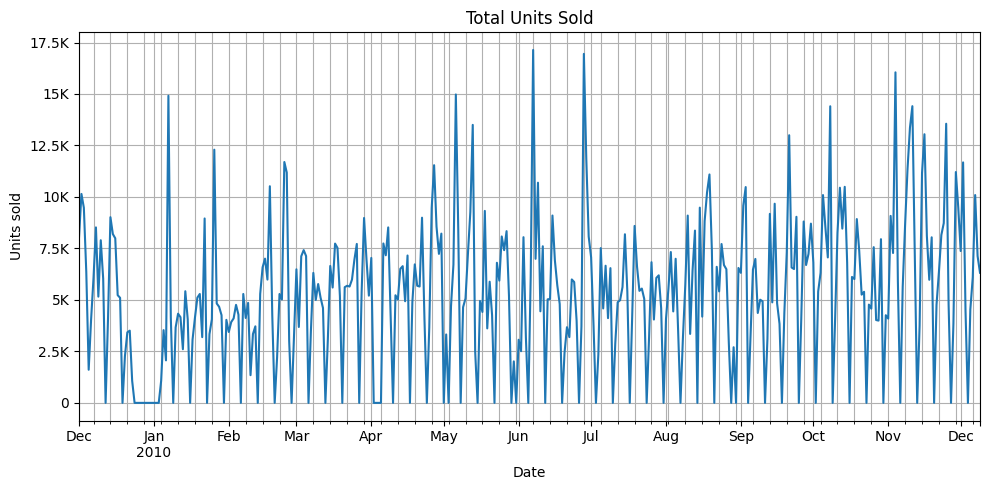

In [104]:
fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['UnitsSold'].sum().plot(ax=ax)

ax.set_title('Total Units Sold')
ax.set_xlabel('Date')
ax.set_ylabel('Units sold')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

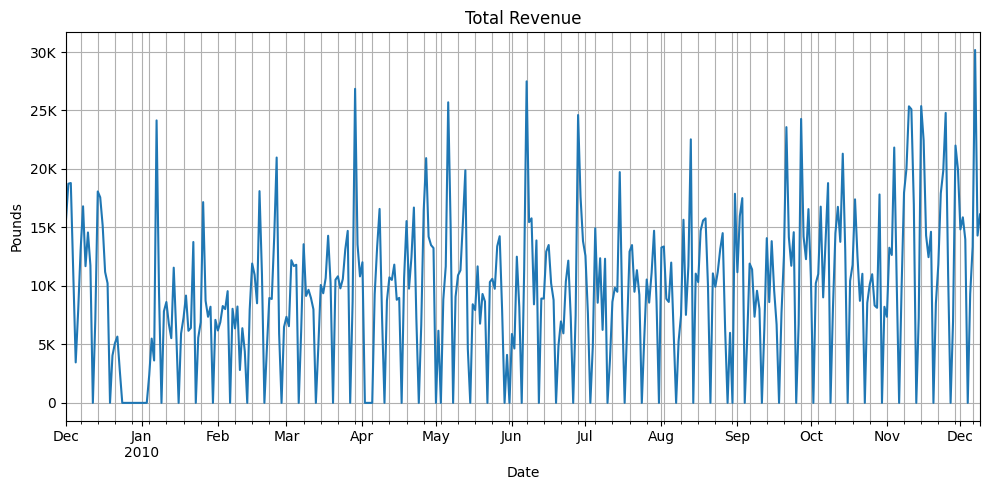

In [105]:
fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['RevenuePounds'].sum().plot(ax=ax)

ax.set_title('Total Revenue')
ax.set_xlabel('Date')
ax.set_ylabel('Pounds')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

## Exploration

In [107]:
df = online_retail_df[['Date', 'UnitsSold', 'RevenuePounds']]

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df.loc[:,'DayOfWeek'] = df['Date'].dt.day_name()
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=day_order, ordered=True)

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df.loc[:, 'Month'] = df['Date'].dt.month_name()

df.loc[:, 'Year'] = df['Date'].dt.year

def sort_year_month(series):
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    year_month_list = series.unique()
    # Parse each YearMonth string into (year, month_index) for sorting
    sortable_list = []
    for ym in year_month_list:
        year, month_name = ym.split('-')
        month_index = month_order.index(month_name)
        sortable_list.append((int(year), month_index, ym))
    sortable_list.sort()
    return [ym for year, month_index, ym in sortable_list]

df['YearMonth'] = df['Year'].astype(str) + '-' + df['Month']
ordered_year_months = sort_year_month(df['YearMonth'])
df['YearMonth_Ordered'] = pd.Categorical(df['YearMonth'], categories=ordered_year_months, ordered=True)

df

,Date,UnitsSold,RevenuePounds,DayOfWeek,Month,Year,YearMonth,YearMonth_Ordered
0,2009-12-01,45,29.90,Tuesday,December,2009,2009-December,2009-December
1,2009-12-02,87,61.75,Wednesday,December,2009,2009-December,2009-December
2,2009-12-03,34,23.40,Thursday,December,2009,2009-December,2009-December
3,2009-12-04,84,55.25,Friday,December,2009,2009-December,2009-December
4,2009-12-05,0,0.00,Saturday,December,2009,2009-December,2009-December
...,...,...,...,...,...,...,...,...
73299,2010-12-05,94,261.30,Sunday,December,2010,2010-December,2010-December
73300,2010-12-06,34,118.06,Monday,December,2010,2010-December,2010-December
73301,2010-12-07,462,1451.10,Tuesday,December,2010,2010-December,2010-December
73302,2010-12-08,35,106.21,Wednesday,December,2010,2010-December,2010-December


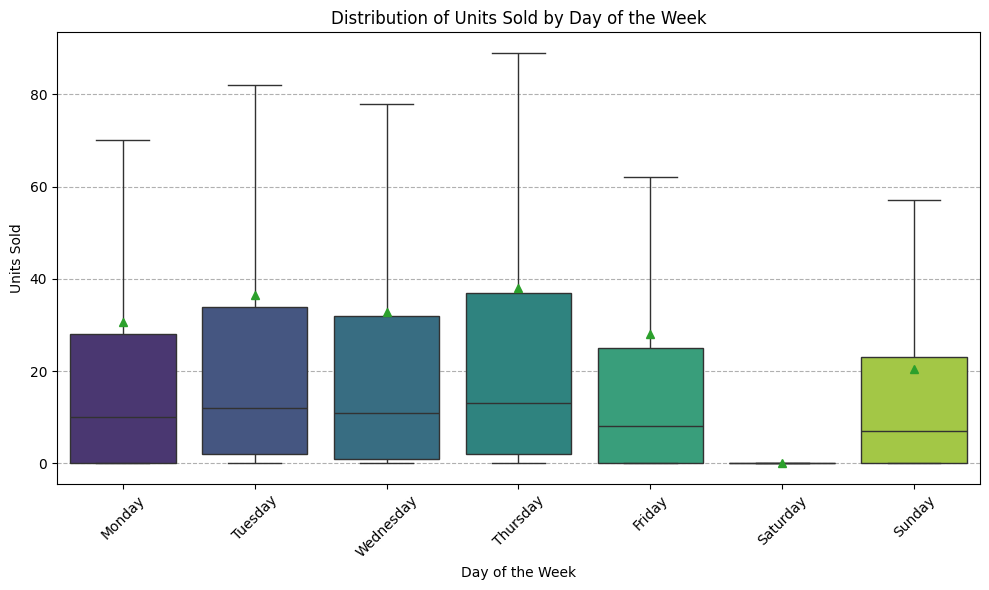

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
Monday,10388.0,30.647382,84.155239,0.0,0.0,10.0,28.0,2654.0
Tuesday,10584.0,36.443689,96.558265,0.0,2.0,12.0,34.0,5005.0
Wednesday,10584.0,32.725435,77.407779,0.0,1.0,11.0,32.0,1684.0
Thursday,10584.0,38.043084,101.188624,0.0,2.0,13.0,37.0,4575.0
Friday,10388.0,27.949750,79.295981,0.0,0.0,8.0,25.0,2976.0
Saturday,10388.0,0.154890,2.505060,0.0,0.0,0.0,0.0,102.0
Sunday,10388.0,20.362437,45.449340,0.0,0.0,7.0,23.0,1230.0


In [108]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='UnitsSold', data=df, order=day_order, palette='viridis', showfliers=False, showmeans=True)
plt.title('Distribution of Units Sold by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
df.groupby('DayOfWeek')['UnitsSold'].describe()

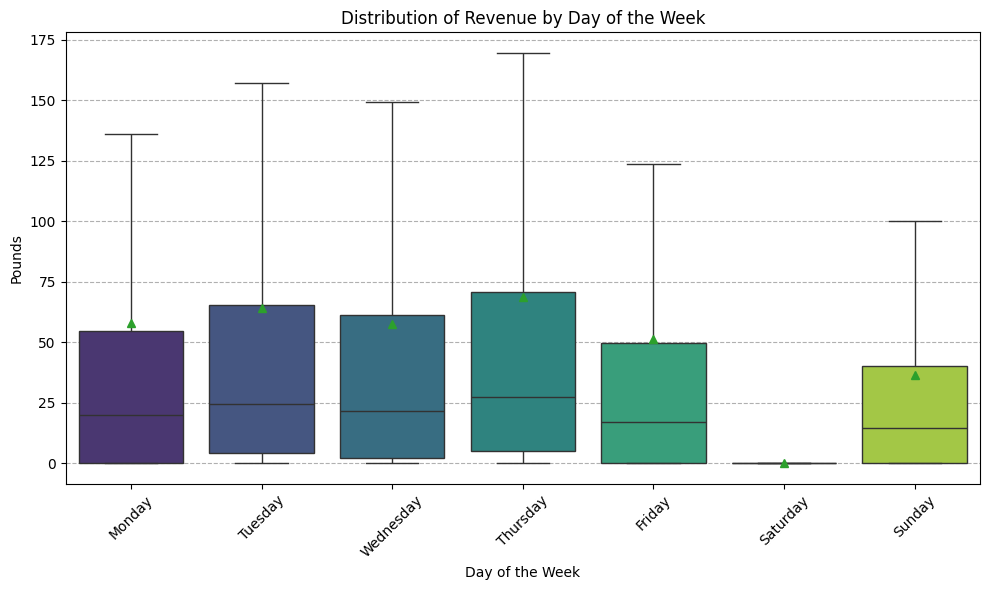

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
Monday,10388.0,57.766026,159.047443,0.0,0.0000,19.880,54.4650,4464.72
Tuesday,10584.0,64.247389,151.828640,0.0,4.1925,24.570,65.4075,5200.23
Wednesday,10584.0,57.489194,130.050335,0.0,2.4175,21.450,61.2000,4813.40
Thursday,10584.0,68.587867,160.319184,0.0,4.9500,27.245,70.8000,4620.64
Friday,10388.0,51.353347,140.898653,0.0,0.0000,16.980,49.5000,5031.72
Saturday,10388.0,0.333150,5.732551,0.0,0.0000,0.000,0.0000,249.60
Sunday,10388.0,36.620894,82.109701,0.0,0.0000,14.700,40.0000,1962.90


In [109]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='RevenuePounds', data=df, order=day_order, palette='viridis', showfliers=False, showmeans=True)
plt.title('Distribution of Revenue by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Pounds')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
df.groupby('DayOfWeek')['RevenuePounds'].describe()

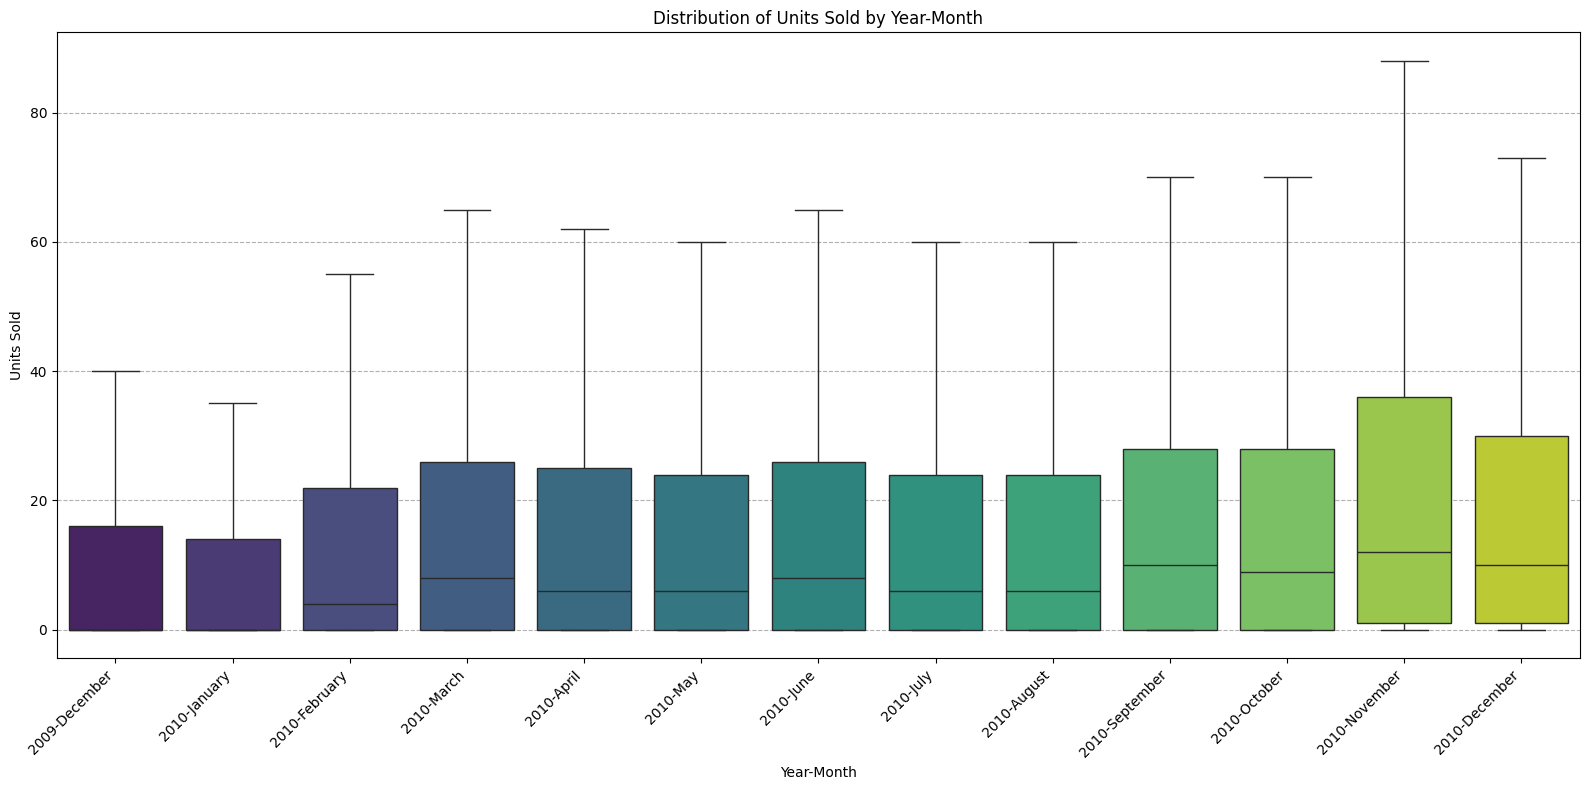

,count,mean,std,min,25%,50%,75%,max
YearMonth,,,,,,,,
2009-December,6076.0,20.291639,61.415717,0.0,0.0,0.0,16.0,1610.0
2010-April,5880.0,26.354082,63.989996,0.0,0.0,6.0,25.0,1200.0
2010-August,6076.0,27.062377,72.428966,0.0,0.0,6.0,24.0,2362.0
2010-December,1764.0,32.730159,114.891755,0.0,1.0,10.0,30.0,3264.0
2010-February,5488.0,22.697340,62.433656,0.0,0.0,4.0,22.0,1587.0
2010-January,6076.0,19.295918,59.805512,0.0,0.0,0.0,14.0,1193.0
2010-July,6076.0,23.196675,51.398740,0.0,0.0,6.0,24.0,759.0
2010-June,5880.0,29.345408,90.058636,0.0,0.0,8.0,26.0,2654.0
2010-March,6076.0,26.674786,63.457481,0.0,0.0,8.0,26.0,2016.0


In [43]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='YearMonth', y='UnitsSold', data=df, palette='viridis', showfliers=False)
plt.title('Distribution of Units Sold by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Units Sold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
df.groupby('YearMonth')['UnitsSold'].describe()

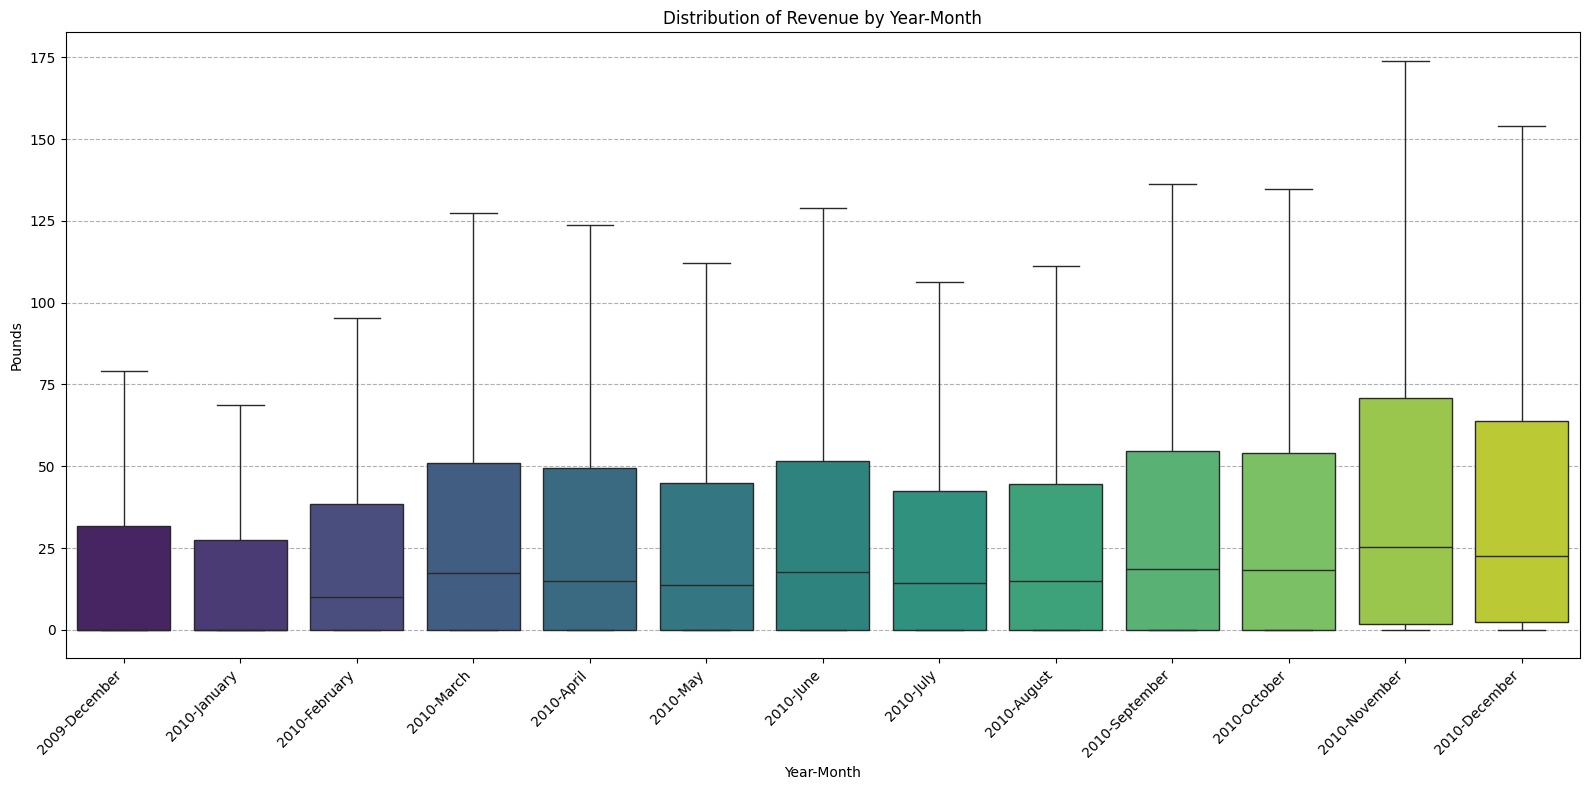

,count,mean,std,min,25%,50%,75%,max
YearMonth,,,,,,,,
2009-December,6076.0,39.559888,127.122327,0.0,0.00,0.000,31.6875,4166.55
2010-April,5880.0,46.854810,104.551433,0.0,0.00,14.850,49.5000,2285.85
2010-August,6076.0,49.331532,124.476960,0.0,0.00,14.945,44.5500,3081.52
2010-December,1764.0,72.518163,249.848033,0.0,2.31,22.500,63.9550,5200.23
2010-February,5488.0,38.939206,90.807356,0.0,0.00,10.040,38.3500,1229.90
2010-January,6076.0,33.124235,105.390073,0.0,0.00,0.000,27.5275,3071.35
2010-July,6076.0,42.979592,115.716059,0.0,0.00,14.300,42.5000,3156.25
2010-June,5880.0,50.713082,140.377401,0.0,0.00,17.600,51.6075,3859.10
2010-March,6076.0,48.386004,115.713403,0.0,0.00,17.400,51.0000,3730.90


In [110]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='YearMonth', y='RevenuePounds', data=df, palette='viridis', showfliers=False)
plt.title('Distribution of Revenue by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Pounds')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
df.groupby('YearMonth')['RevenuePounds'].describe()

In [111]:
pivoted_df = online_retail_df.pivot(index='Date', columns='Description', values=['UnitsSold', 'RevenuePounds'])
pivoted_df

UnitsSold                            \
Description 12 pencils small tube red spotty 12 pencils tall tube posy   
Date                                                                     
2009-12-01                              45.0                      69.0   
2009-12-02                              87.0                      87.0   
2009-12-03                              34.0                     116.0   
2009-12-04                              84.0                     160.0   
2009-12-05                               0.0                      24.0   
...                                      ...                       ...   
2010-12-05                             151.0                       6.0   
2010-12-06                             135.0                       4.0   
2010-12-07                              20.0                      15.0   
2010-12-08                              75.0                       0.0   
2010-12-09                              35.0                       2.0   

                                                                    \
Description 12 pencils tall tube woodland 3 stripey mice feltcraft   
Date                                                                 
2009-12-01                            4.0                      9.0   
2009-12-02                           21.0                     19.0   
2009-12-03                           13.0                    101.0   
2009-12-04                           25.0                      7.0   
2009-12-05                            0.0                      0.0   
...                                   ...                      ...   
2010-12-05                           15.0                      4.0   
2010-12-06                           17.0                     36.0   
2010-12-07                            9.0                      9.0   
2010-12-08                           23.0                     14.0   
2010-12-09                           43.0                     31.0   

                                                                \
Description 6 ribbons rustic charm 60 teatime fairy cake cases   
Date                                                             
2009-12-01                    27.0                       173.0   
2009-12-02                     7.0                       159.0   
2009-12-03                     3.0                       201.0   
2009-12-04                     2.0                        99.0   
2009-12-05                     0.0                         0.0   
...                            ...                         ...   
2010-12-05                    49.0                         9.0   
2010-12-06                    38.0                        57.0   
2010-12-07                    37.0                        30.0   
2010-12-08                    16.0                        77.0   
2010-12-09                    20.0                        61.0   

                                                                            \
Description 72 sweetheart fairy cake cases airline bag vintage jet set red   
Date                                                                         
2009-12-01                            50.0                             0.0   
2009-12-02                           229.0                             0.0   
2009-12-03                            83.0                             0.0   
2009-12-04                             3.0                             0.0   
2009-12-05                             0.0                             0.0   
...                                    ...                             ...   
2010-12-05                            19.0                             8.0   
2010-12-06                             1.0                            10.0   
2010-12-07                            28.0                             8.0   
2010-12-08                            82.0                             5.0   
2010-12-09                            33.0                             3.0   


In [114]:
online_retail_df.groupby('Description')[['UnitsSold', 'RevenuePounds']].sum().sort_values(by='UnitsSold', ascending=False)

,UnitsSold,RevenuePounds
Description,,
pack of 72 retro spot cake cases,60141,31738.10
white hanging heart tlight holder,58792,160630.78
world war 2 gliders asstd designs,55091,11418.05
hanging heart zinc tlight holder,49214,66479.86
assorted colour bird ornament,45348,73092.99
...,...,...
retro spot storage jar,1840,7303.49
retro spots butter dish,1812,9094.84
doorstop retrospot heart,1334,5243.16


## Distribution analysis

In [115]:
sample_products = online_retail_df.groupby('Description')['UnitsSold'].sum().sort_values(ascending=False).index.values

In [234]:
def visualize_product_series(time_series: pd.Series, product_name: str, series_name: str = "Value"):
    """
    Visualizes a time series for a given product, including time plot, weekly and monthly
    box plots, histogram, log histogram, ACF, PACF plots, and per-weekday histograms.

    Args:
        time_series: A pandas Series with dates as the index and the values of the time series
                     (e.g., units sold or revenue).
        product_name: The name of the product (for plot titles).
        series_name: The name of the series being visualized (e.g., "Units Sold", "Revenue in Pounds")
                     for y-axis labels and specific plot titles.
    """
    plt.figure(figsize=(20, 20)) # Increased figure size to accommodate the new subplot
    plt.suptitle(f"Analysis of {series_name} for {product_name}", fontsize=16)

    # 1. Plot the time series
    plt.subplot(5, 2, 1)
    time_series.plot(title=f'Daily {series_name}')
    plt.xlabel('Date')
    plt.ylabel(series_name)
    plt.grid(True)

    # 2. Plot a box plot by day of the week
    plt.subplot(5, 2, 2)
    df_temp = time_series.copy().to_frame(name=series_name)
    df_temp['Day of Week'] = df_temp.index.day_name()
    sns.boxplot(x='Day of Week', y=series_name, data=df_temp, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.title(f'{series_name} by Day of the Week')
    plt.xlabel('Day of the Week')
    plt.ylabel(series_name)

    # 3. Plot a box plot by Month
    plt.subplot(5, 2, 3)
    df_temp['Month'] = df_temp.index.month_name()
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    sns.boxplot(x='Month', y=series_name, data=df_temp, order=month_order)
    plt.title(f'{series_name} by Month')
    plt.xlabel('Month')
    plt.ylabel(series_name)
    plt.xticks(rotation=45, ha='right')

    # 4. Plot a histogram of the value of the time series
    plt.subplot(5, 2, 4)
    sns.histplot(time_series, kde=True)
    plt.title(f'Histogram of Daily {series_name}')
    plt.xlabel(series_name)
    plt.ylabel('Frequency')

    # 5. Plot a log histogram of the time series (excluding zero values)
    plt.subplot(5, 2, 5)
    non_zero_values = time_series[time_series > 0]
    if not non_zero_values.empty:
        sns.histplot(np.log(non_zero_values), kde=True)
        plt.title(f'Log Histogram of Daily {series_name} (Non-Zero)')
        plt.xlabel(f'log({series_name})')
        plt.ylabel('Frequency')
    else:
        plt.title(f'No Non-Zero Values to Plot Log Histogram for {series_name}')

    # 6. Plot per-weekday histograms (excluding zeros, same axes, different colors, alpha=0.5, legend)
    plt.subplot(5, 2, 6)
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    colors = plt.cm.viridis(np.linspace(0, 1, len(days))) # Generate a colormap
    for day, color in zip(days, colors):
        weekday_data = df_temp[df_temp['Day of Week'] == day][series_name]
        non_zero_weekday_data = weekday_data[weekday_data > 0]
        if not non_zero_weekday_data.empty:
            sns.histplot(np.log(non_zero_weekday_data), color=color, alpha=0.5, label=day, kde=False) # kde=False for clarity on overlapping
    plt.title(f'Weekday Distribution of {series_name} (Non-Zero)')
    plt.xlabel(series_name)
    plt.ylabel('Frequency')
    plt.legend()

    # 7. Plot the Autocorrelation Function (ACF)
    plt.subplot(5, 2, 9) # Adjusted subplot index
    plot_acf(time_series, lags=30, ax=plt.gca())
    plt.title(f'Autocorrelation Function (ACF) - {series_name}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')

    # 8. Plot the Partial Autocorrelation Function (PACF)
    plt.subplot(5, 2, 10) # Adjusted subplot index
    plot_pacf(time_series, lags=30, method='ywmle', ax=plt.gca())
    plt.title(f'Partial Autocorrelation Function (PACF) - {series_name}')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

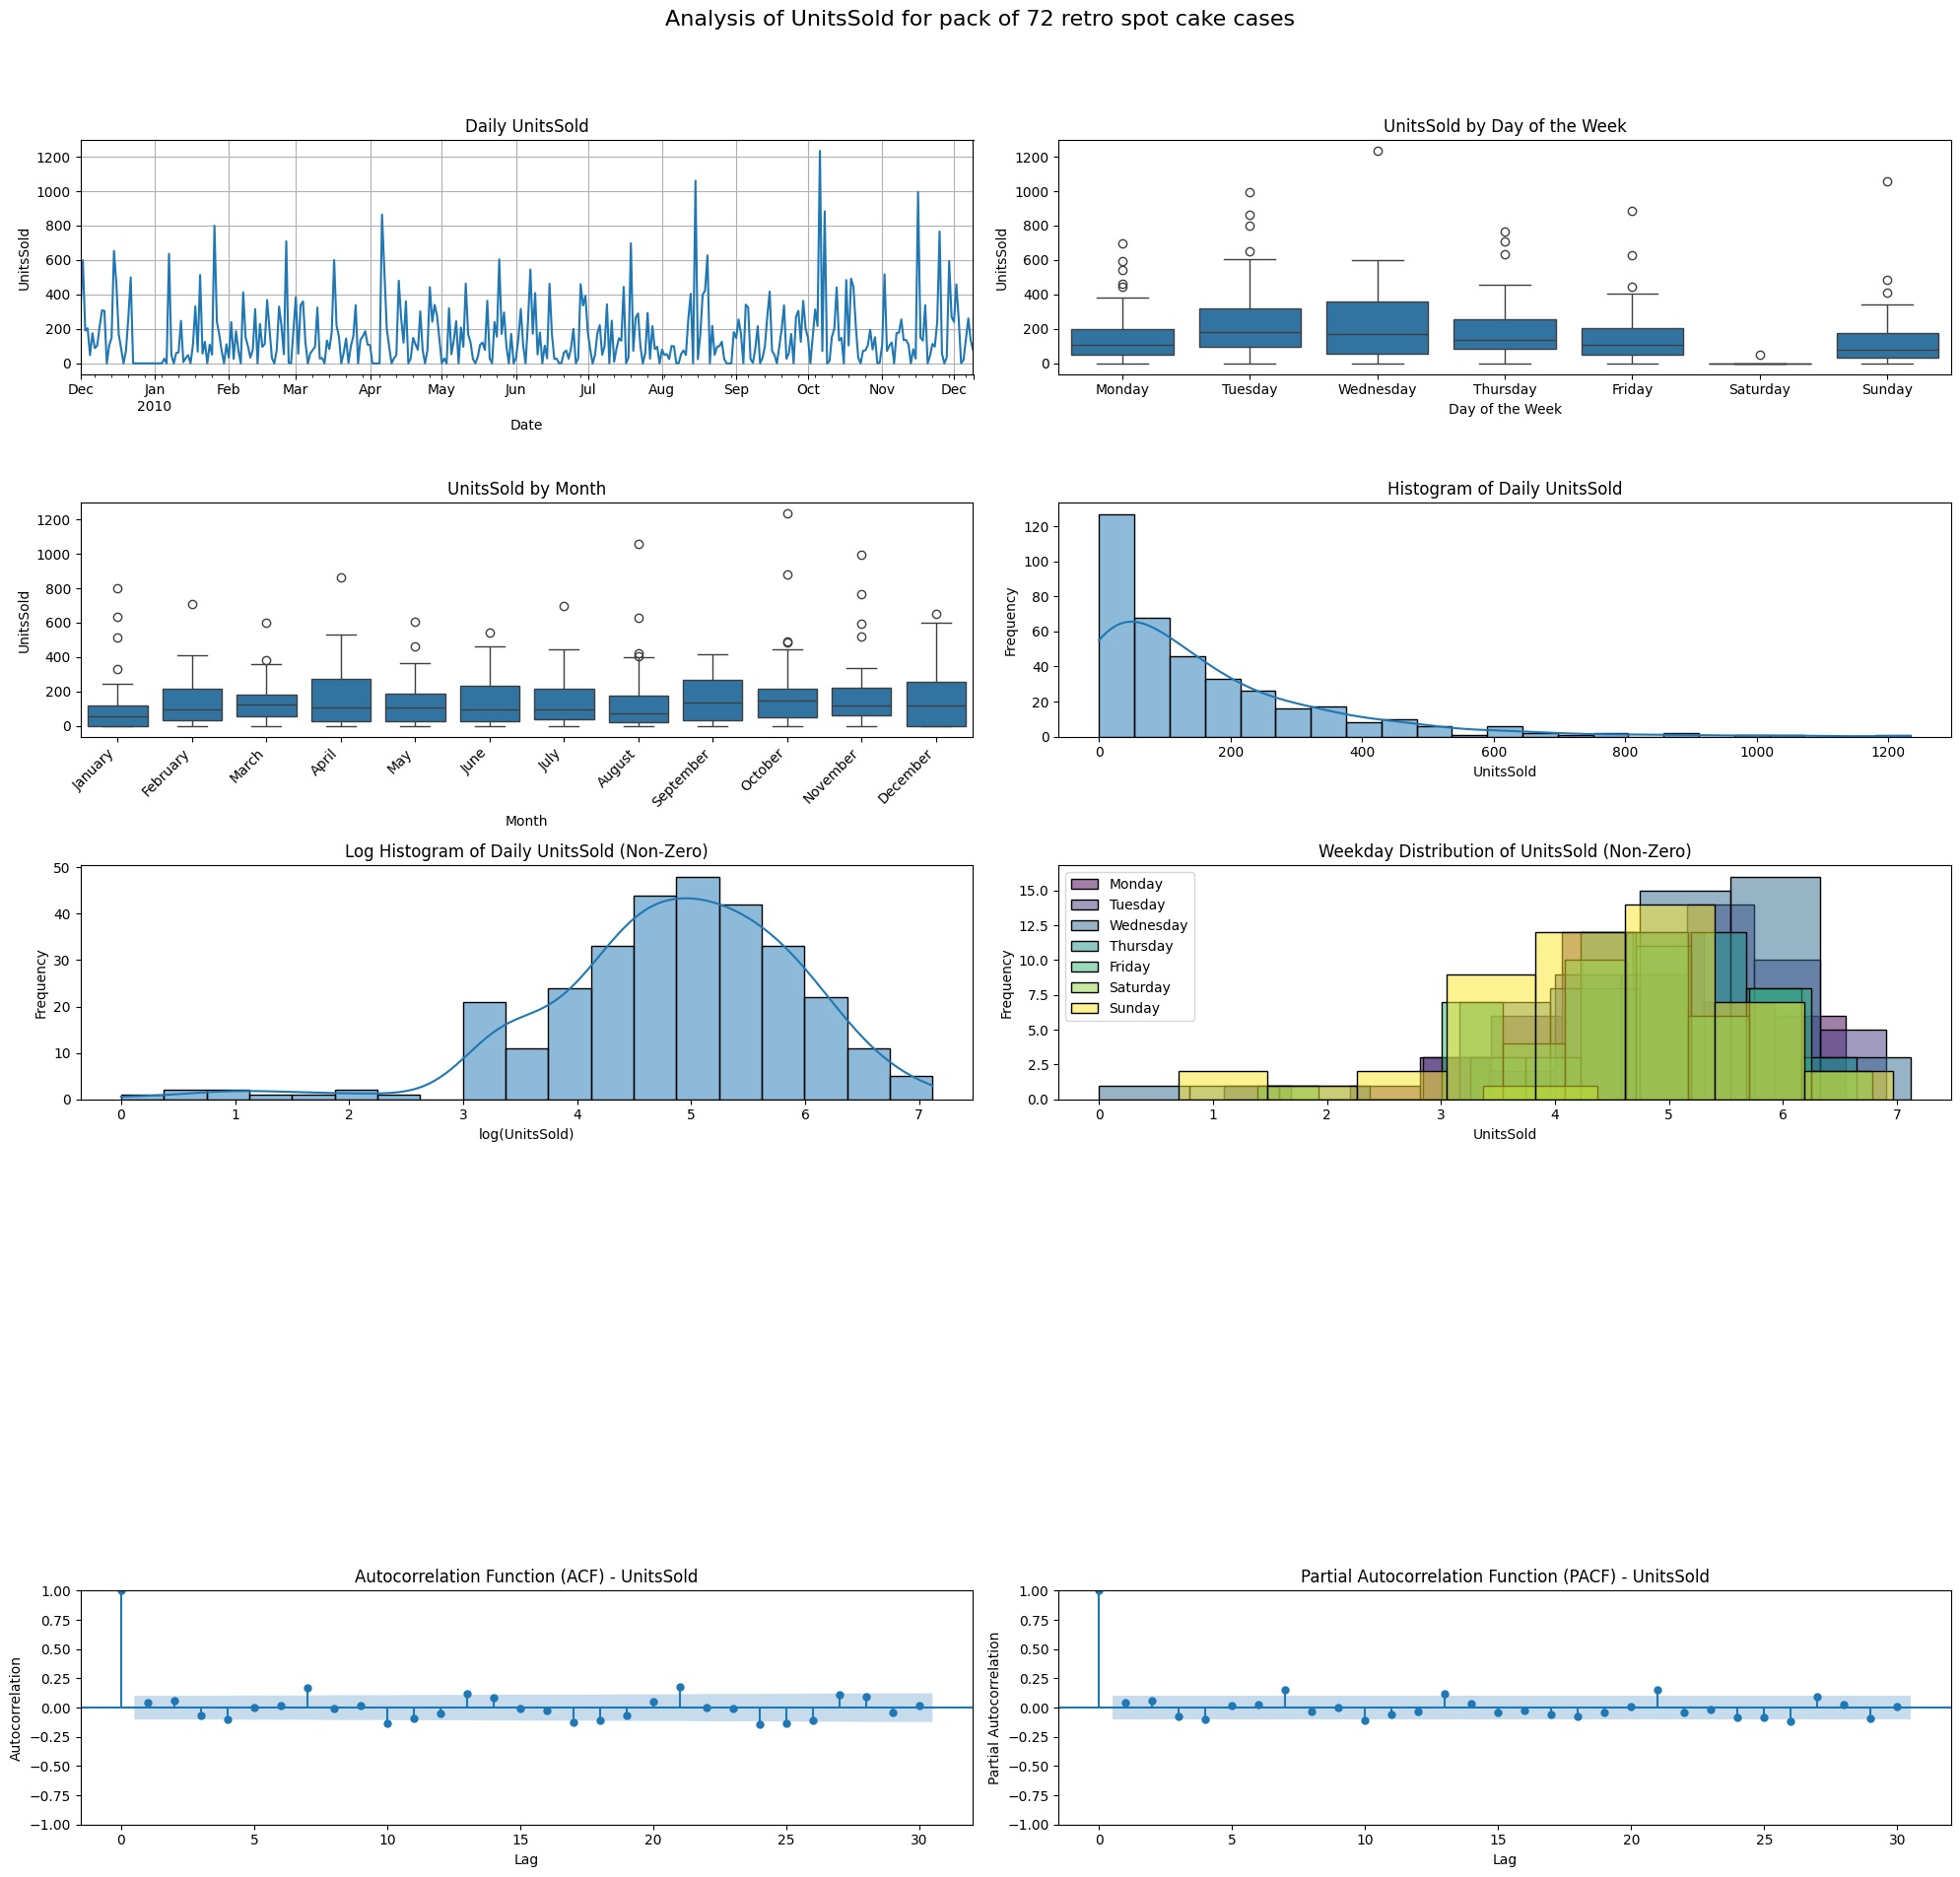

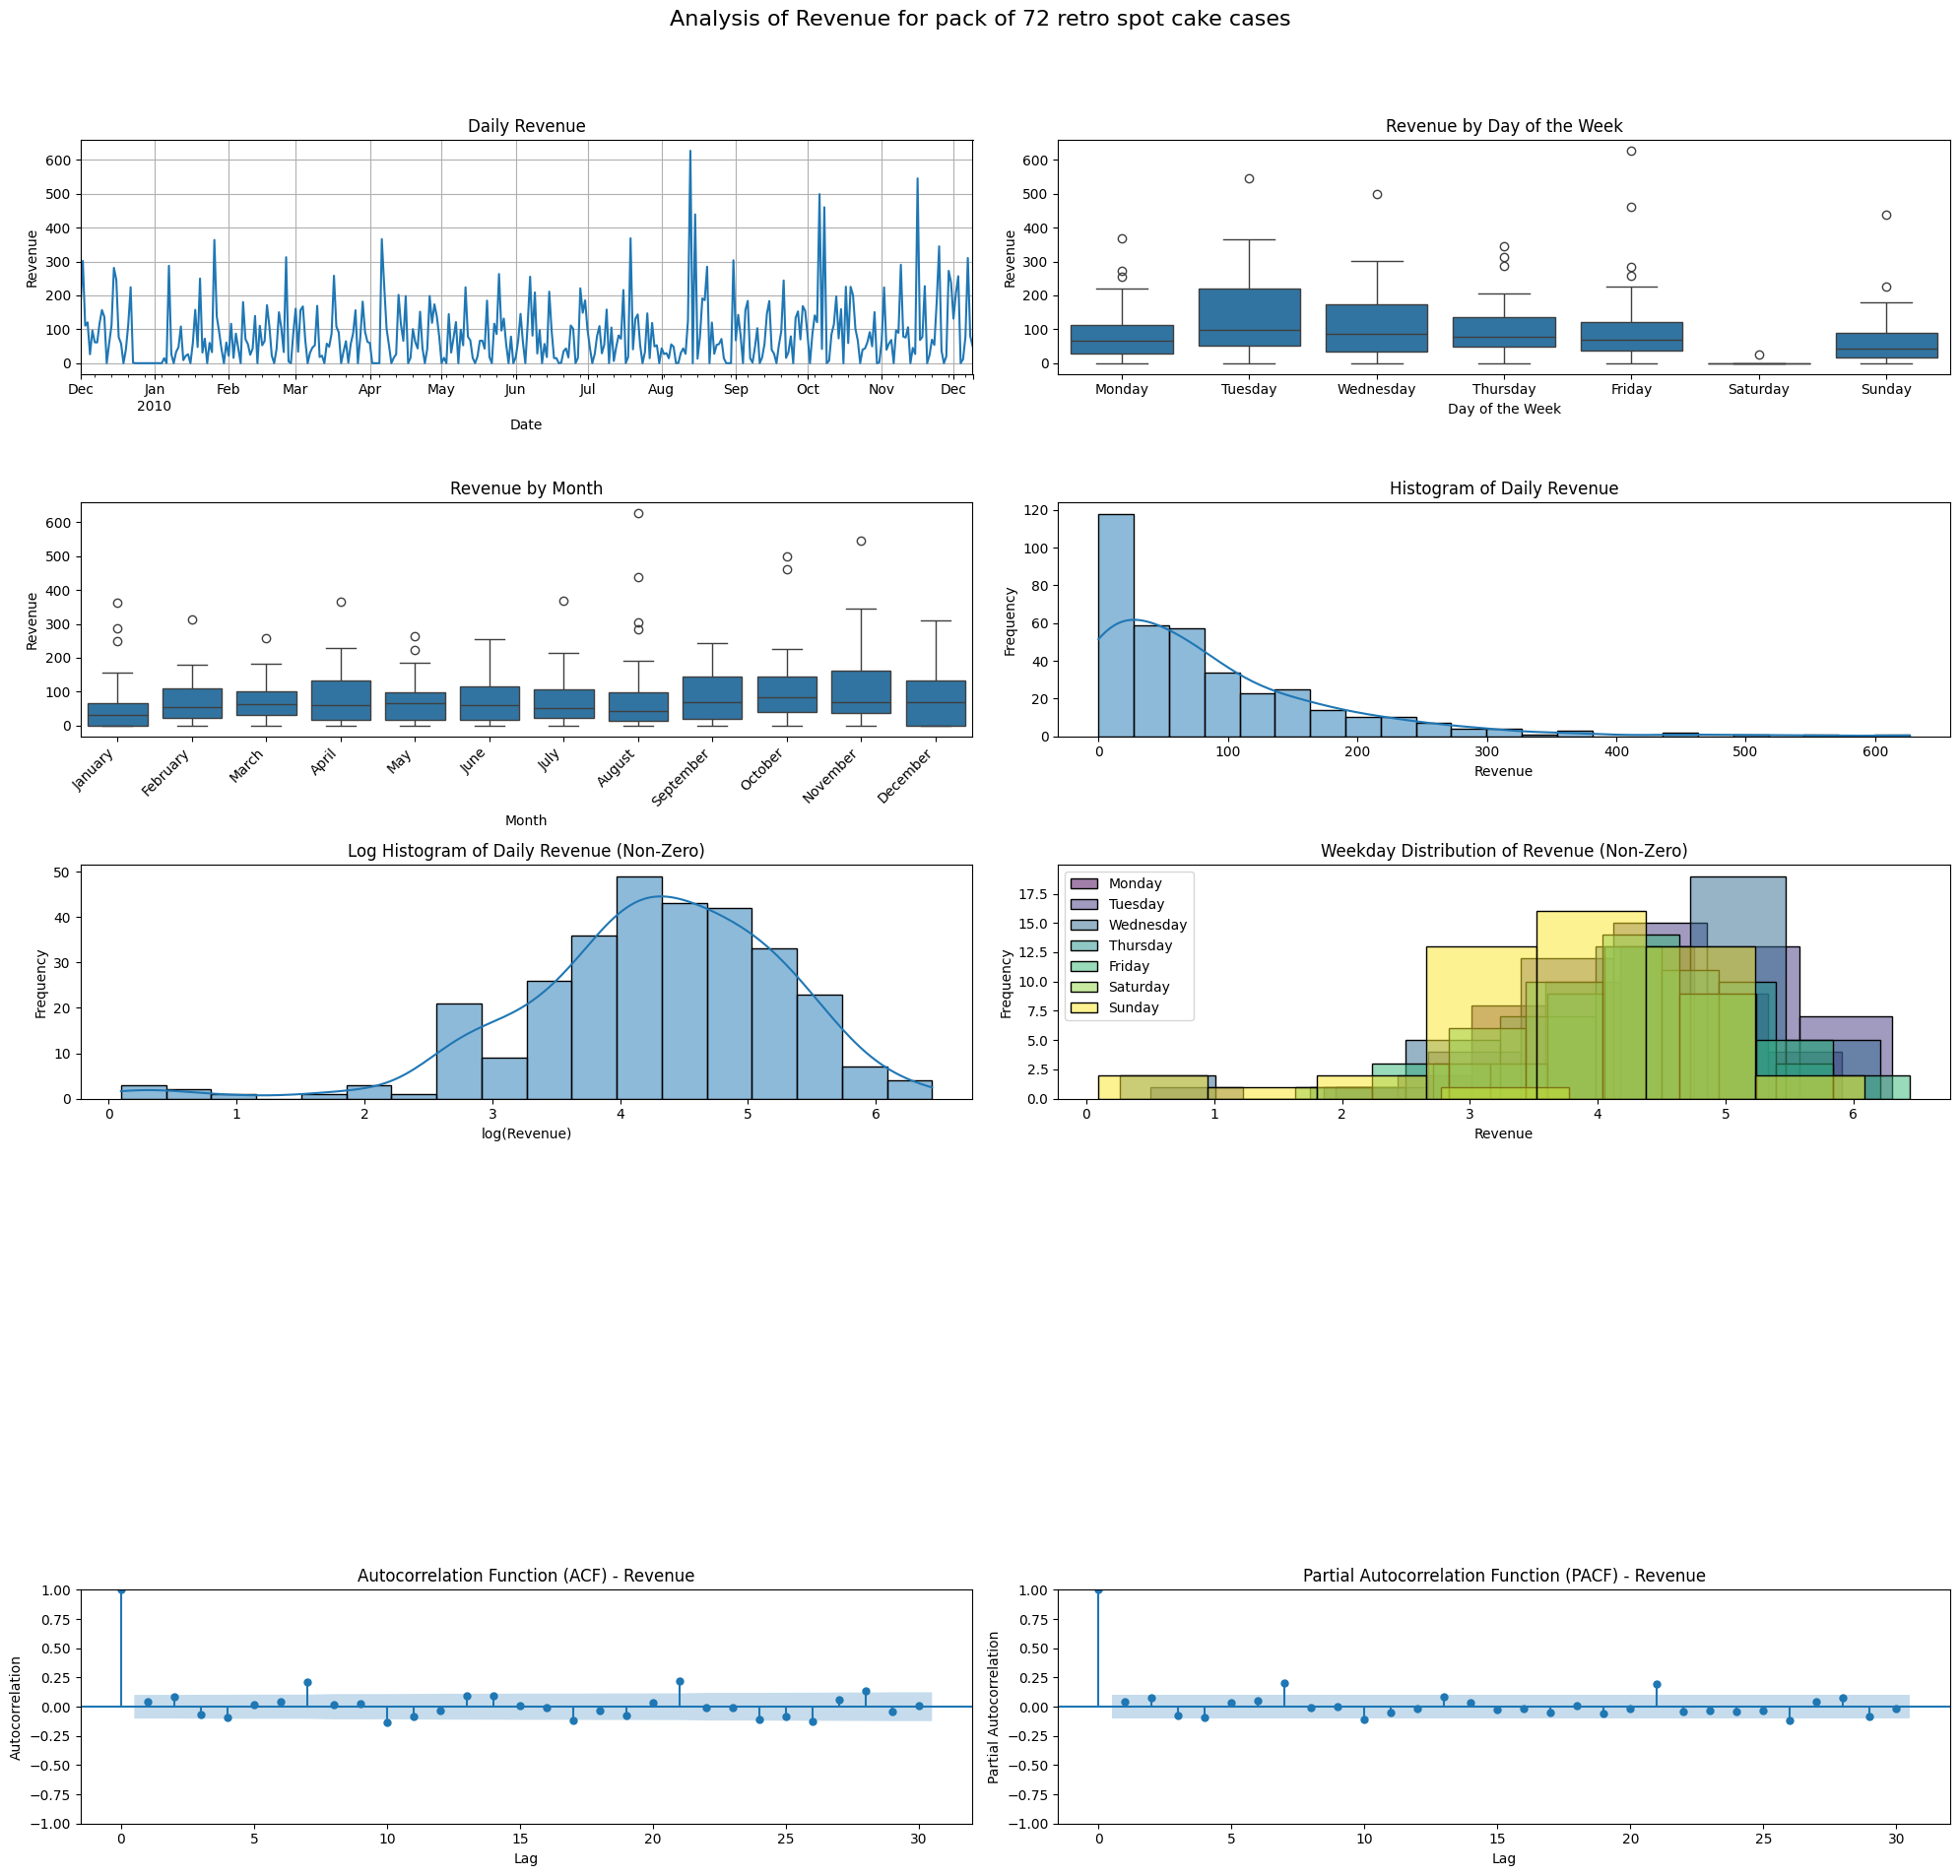

In [235]:
i = 0
visualize_product_series(pivoted_df['UnitsSold'][sample_products[i]], sample_products[i], 'UnitsSold')
visualize_product_series(pivoted_df['RevenuePounds'][sample_products[i]], sample_products[i], 'Revenue')

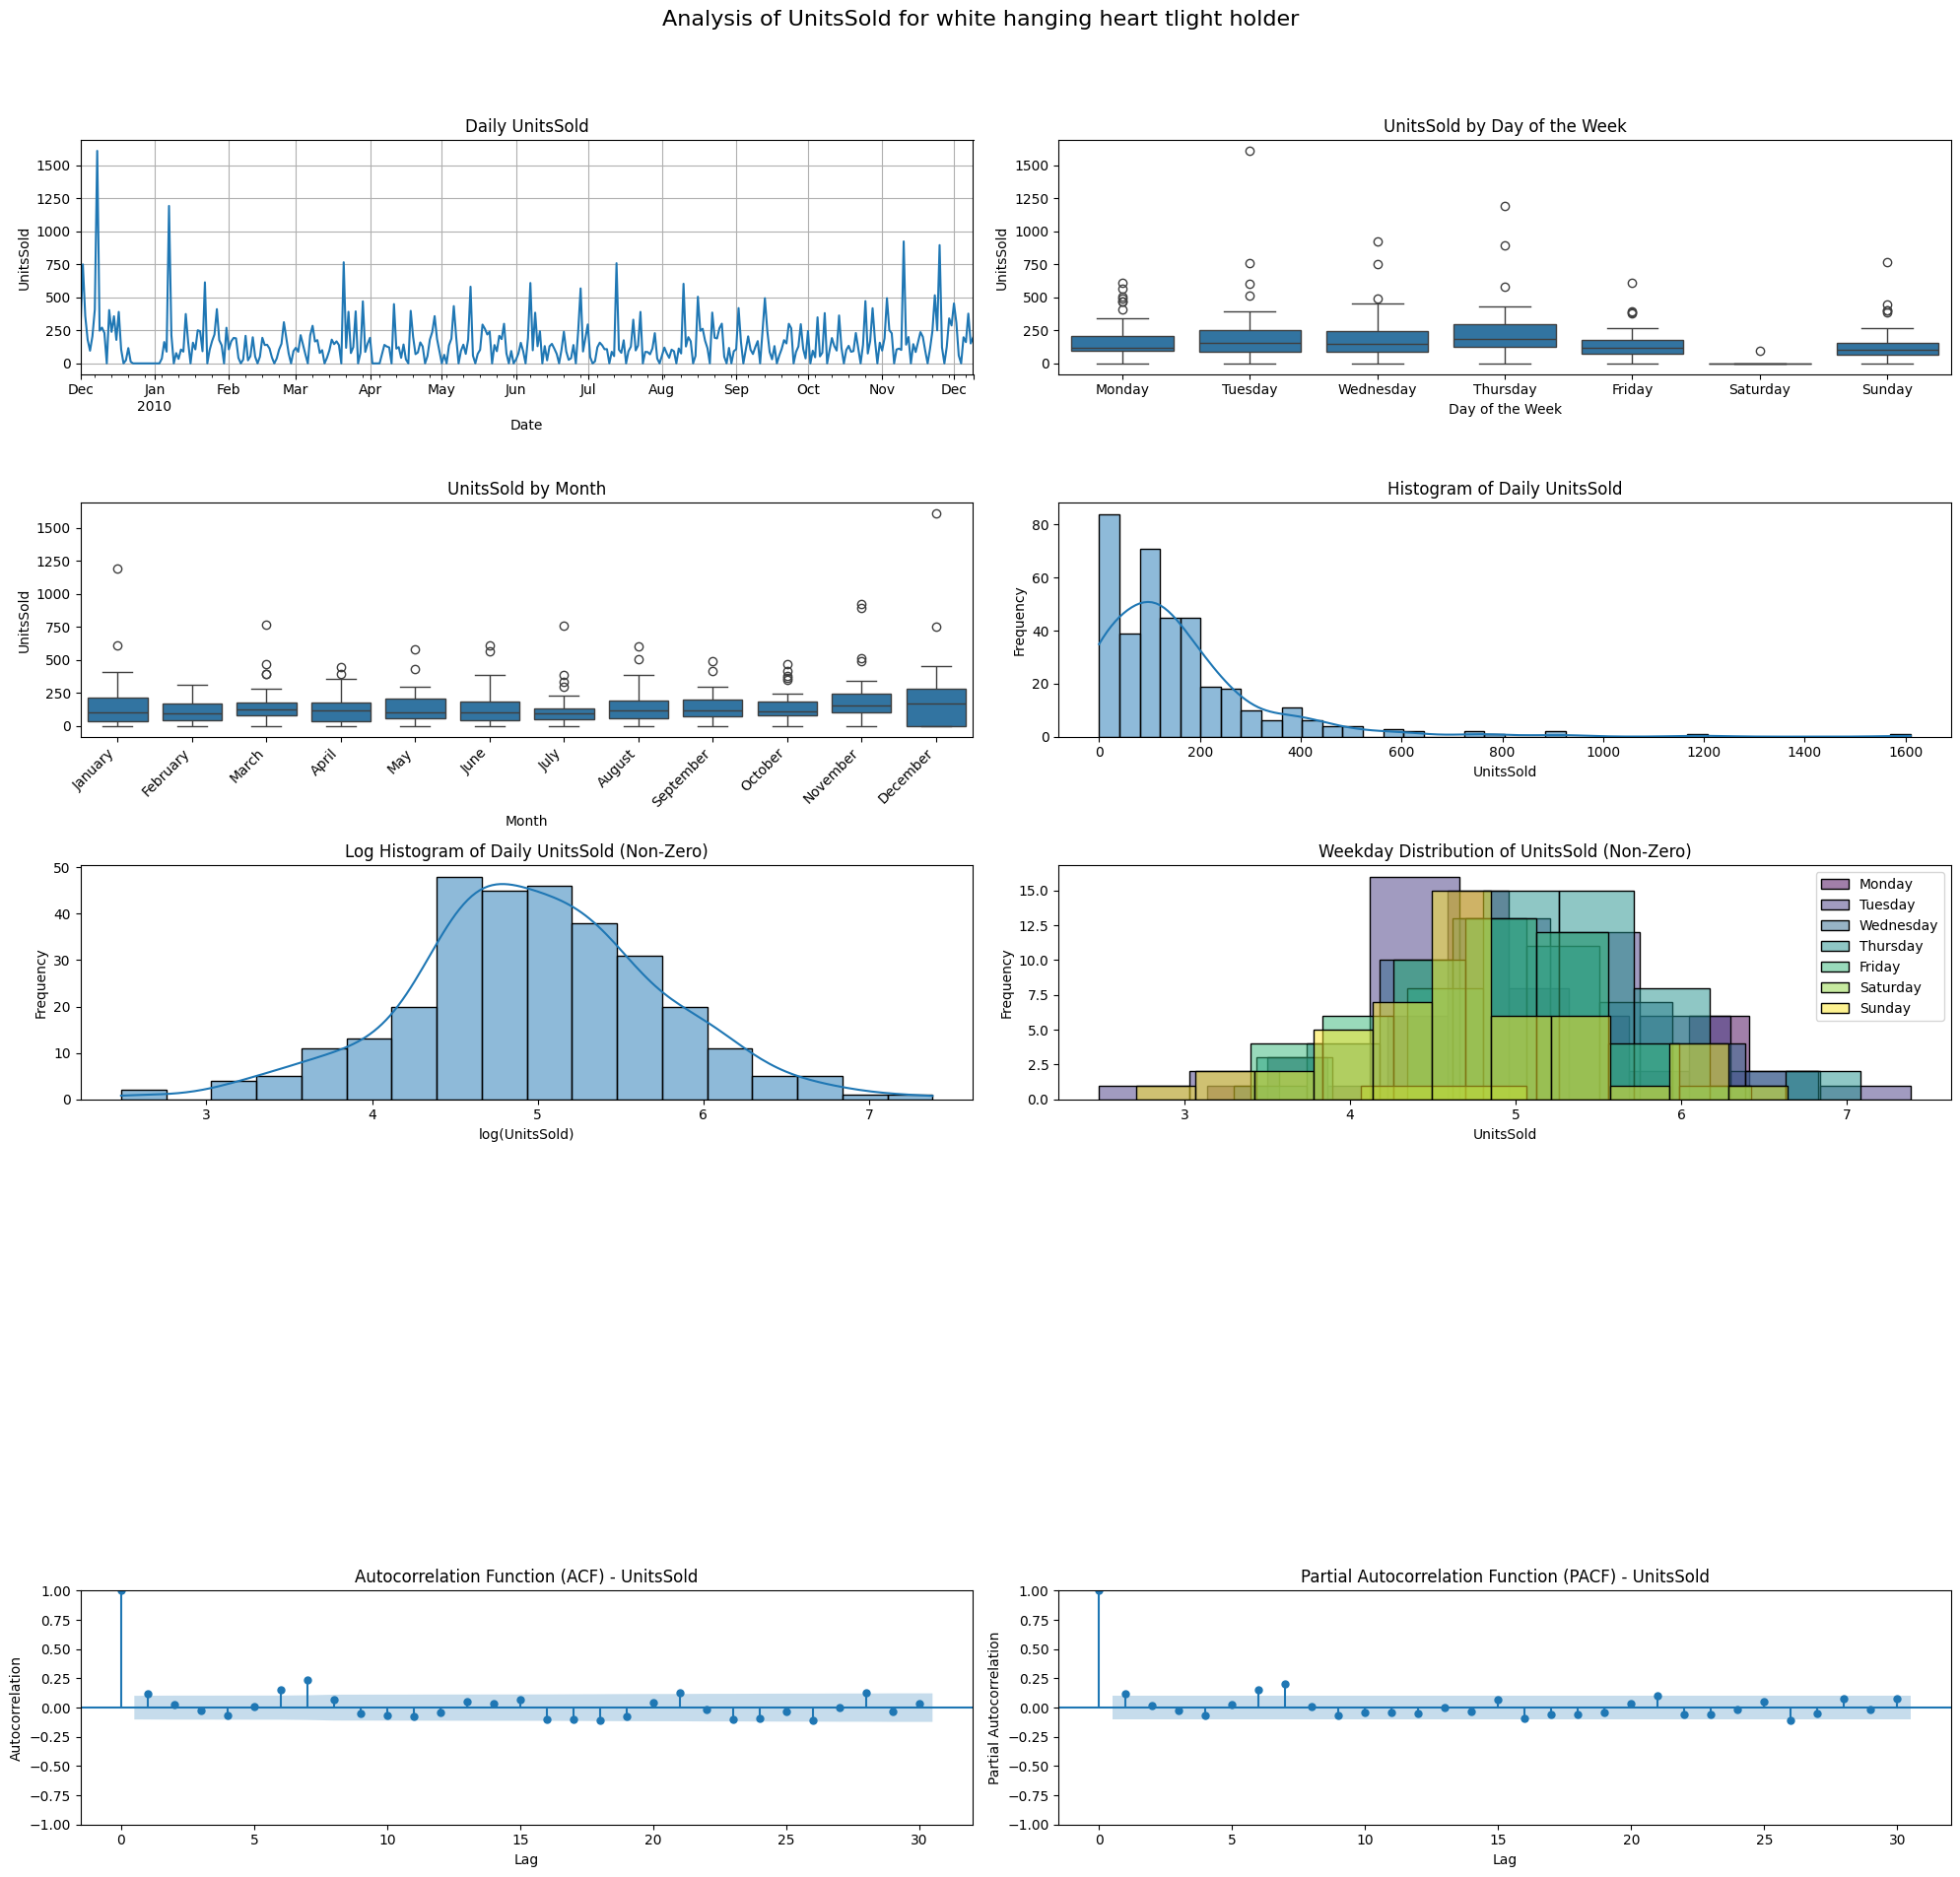

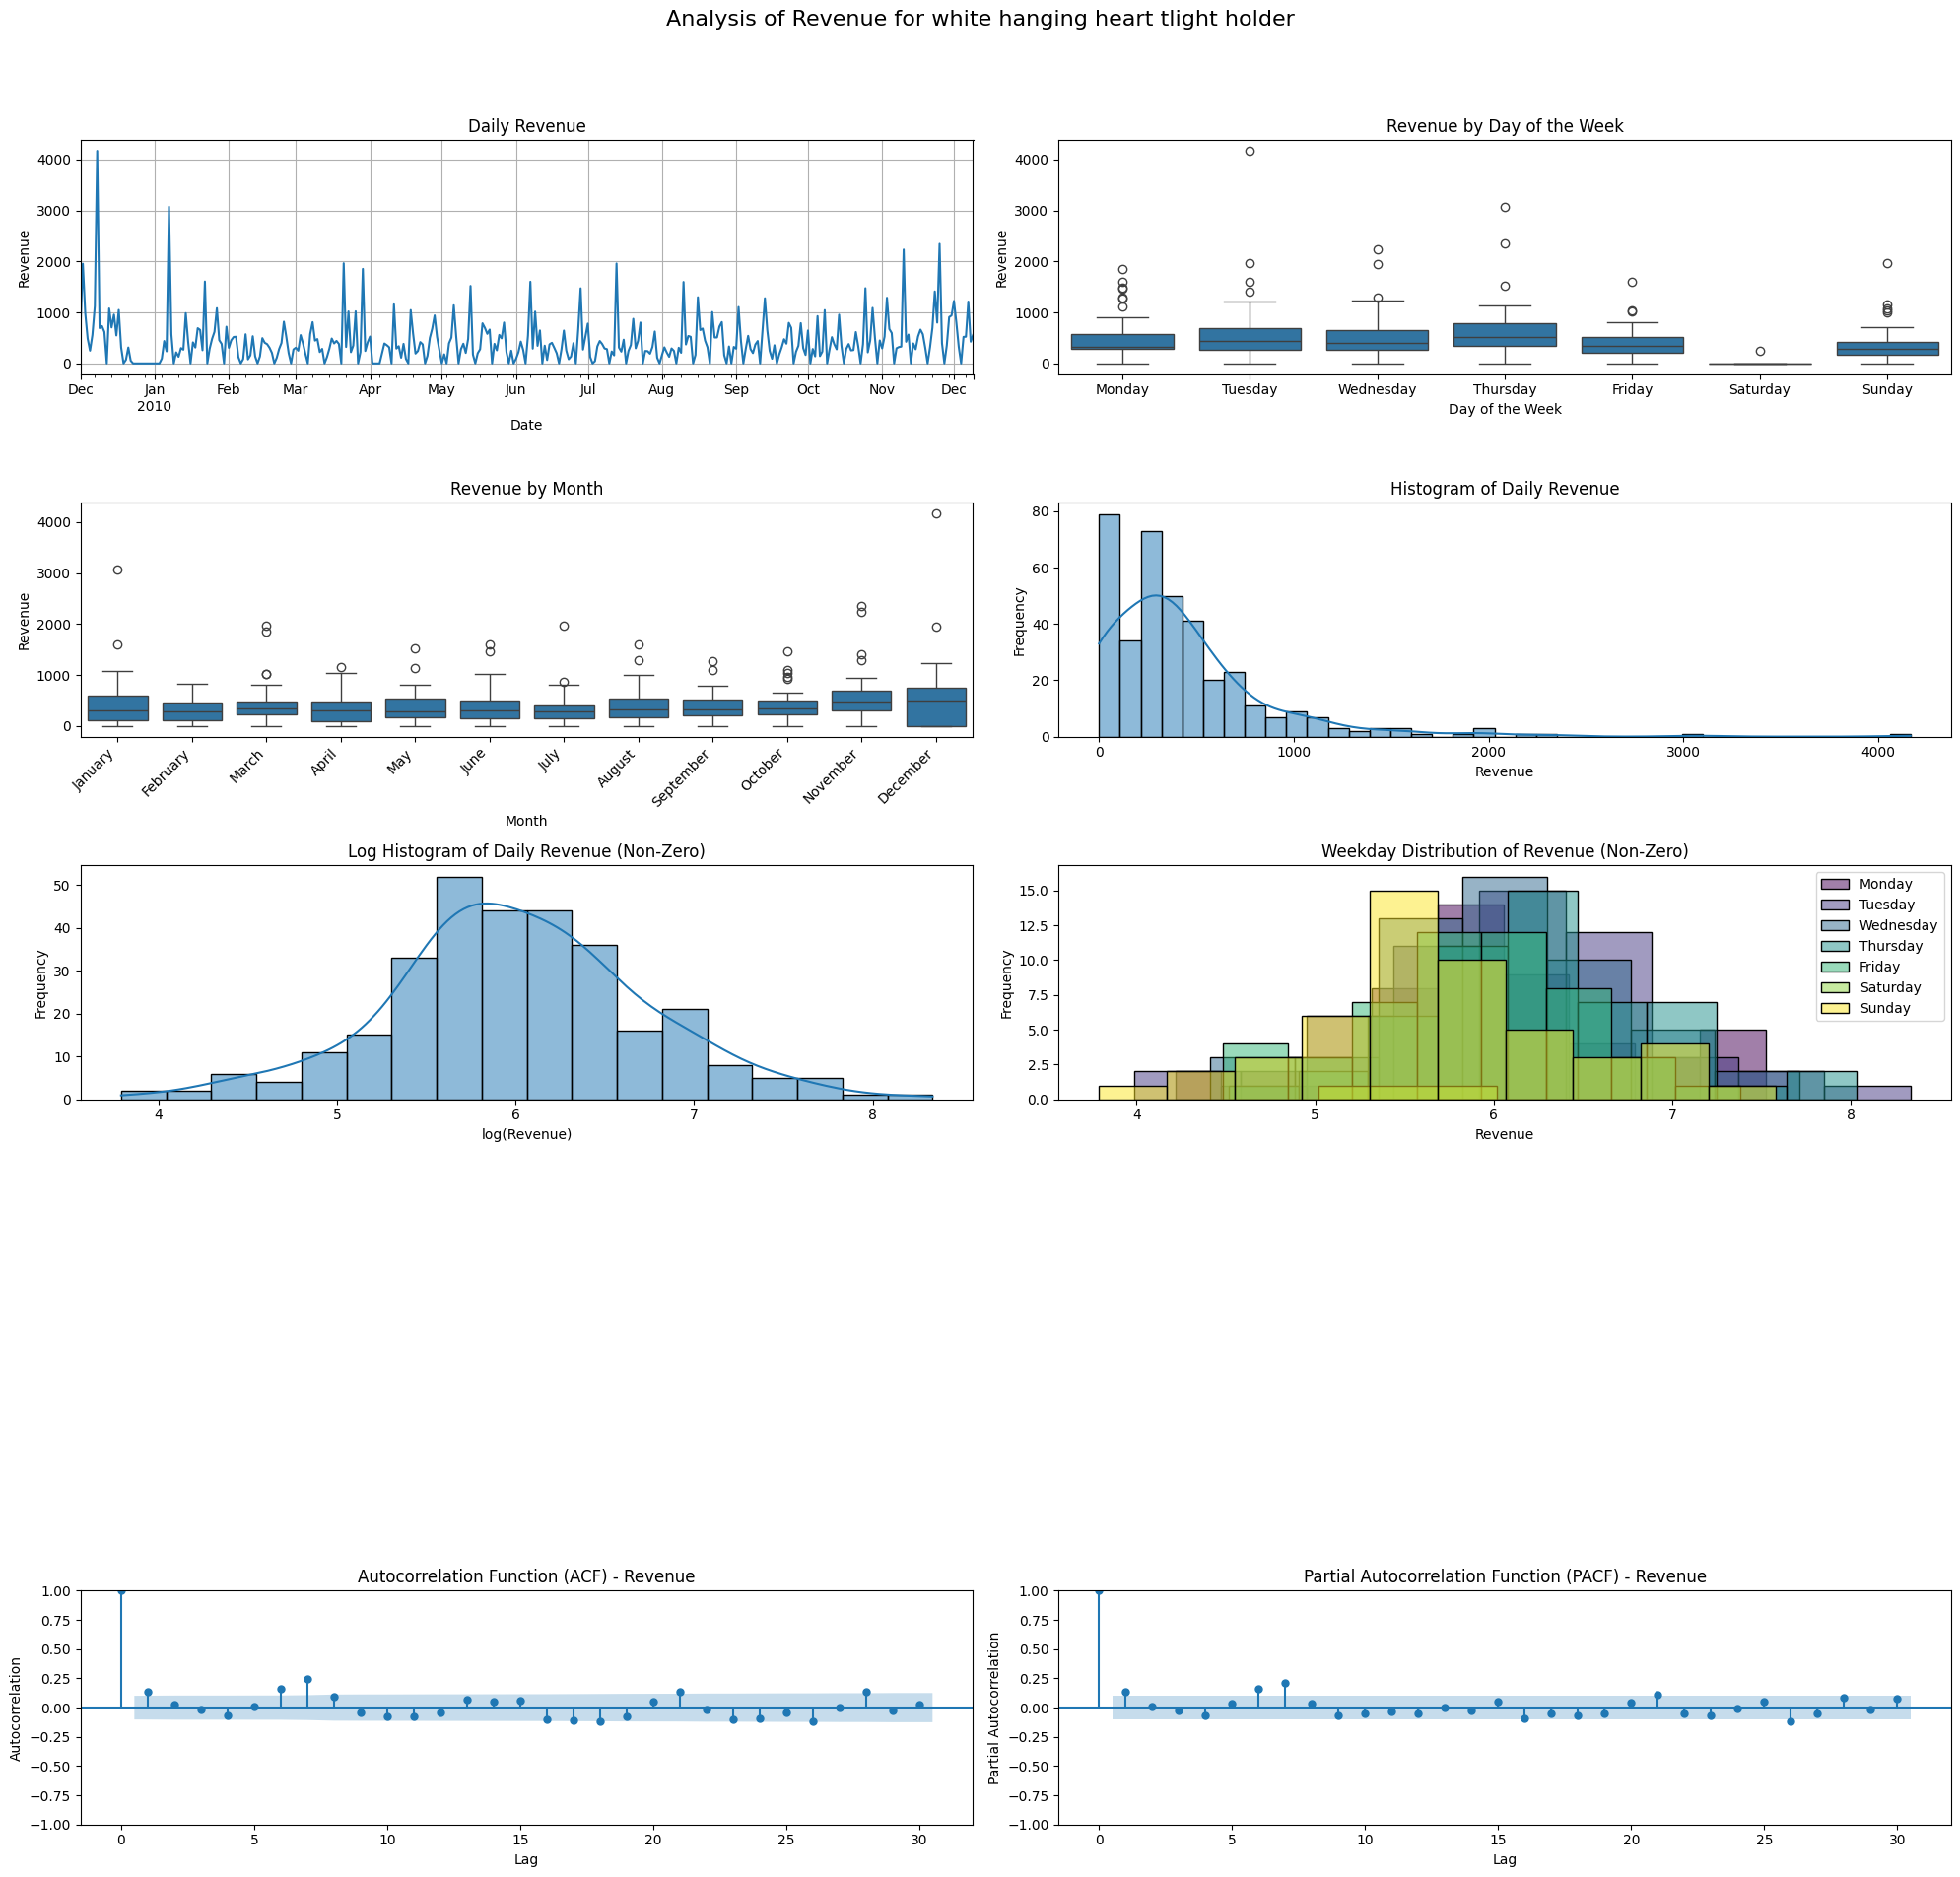

In [236]:
i = 1
visualize_product_series(pivoted_df['UnitsSold'][sample_products[i]], sample_products[i], 'UnitsSold')
visualize_product_series(pivoted_df['RevenuePounds'][sample_products[i]], sample_products[i], 'Revenue')

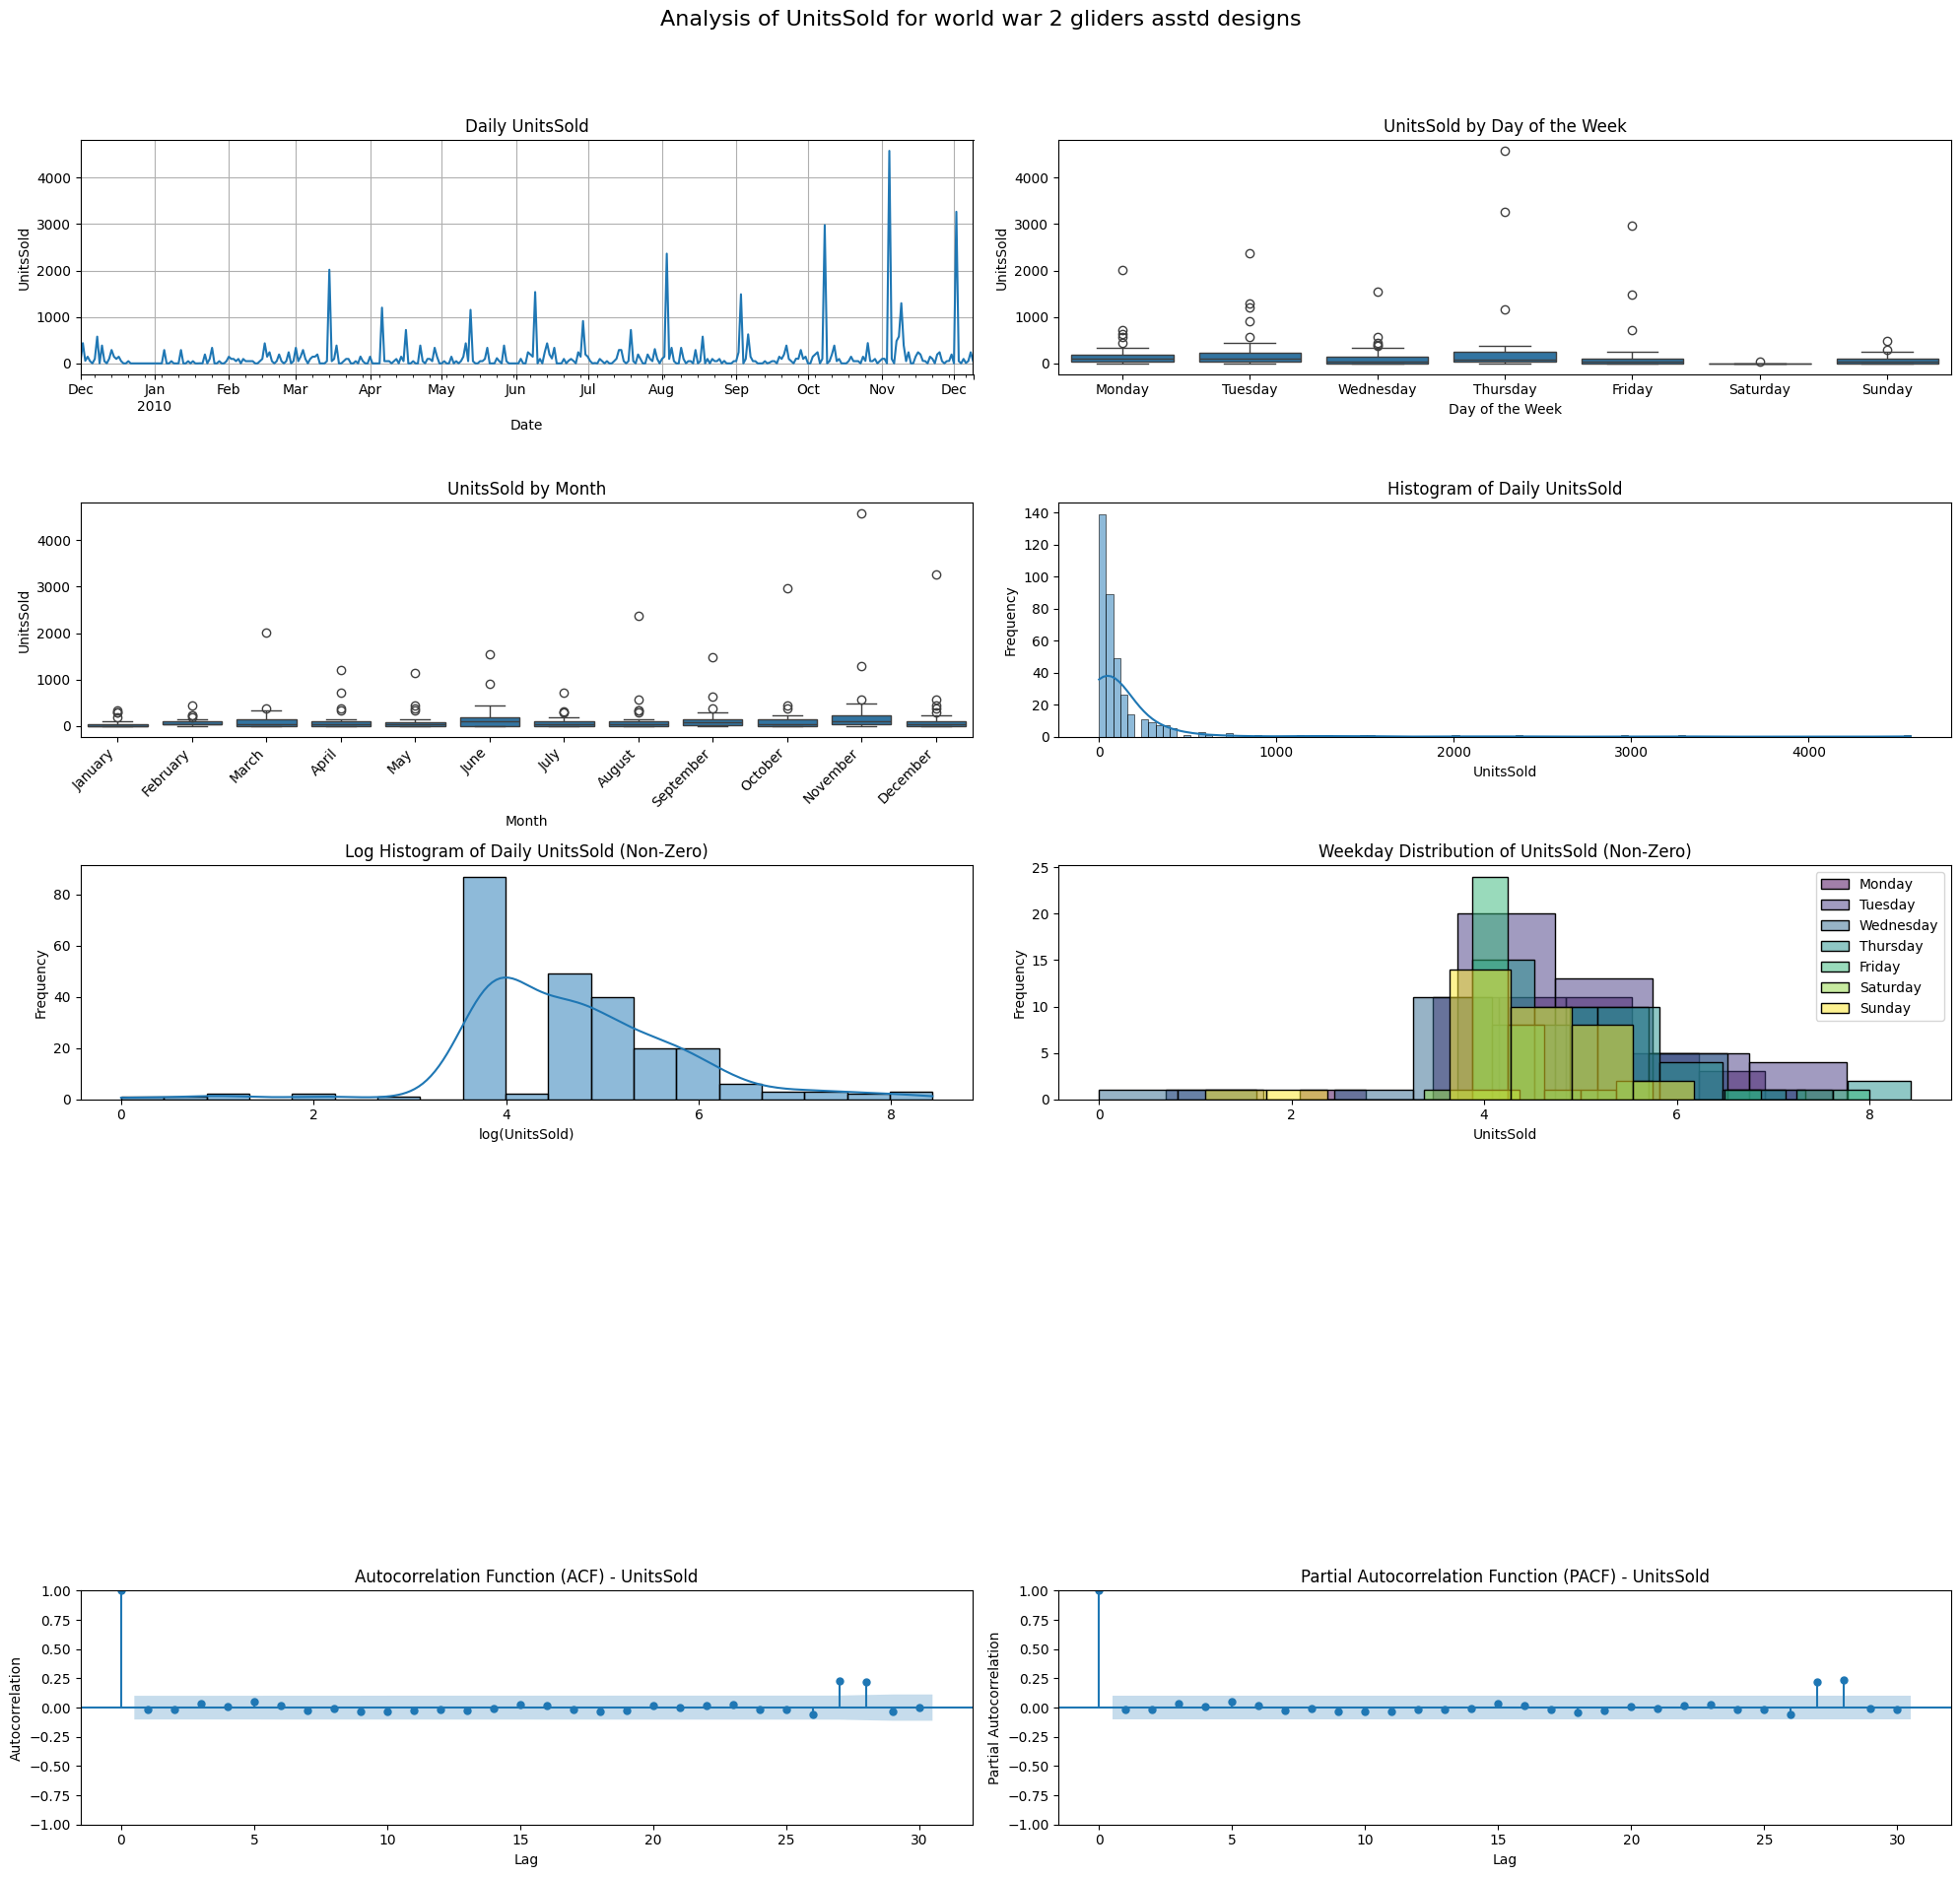

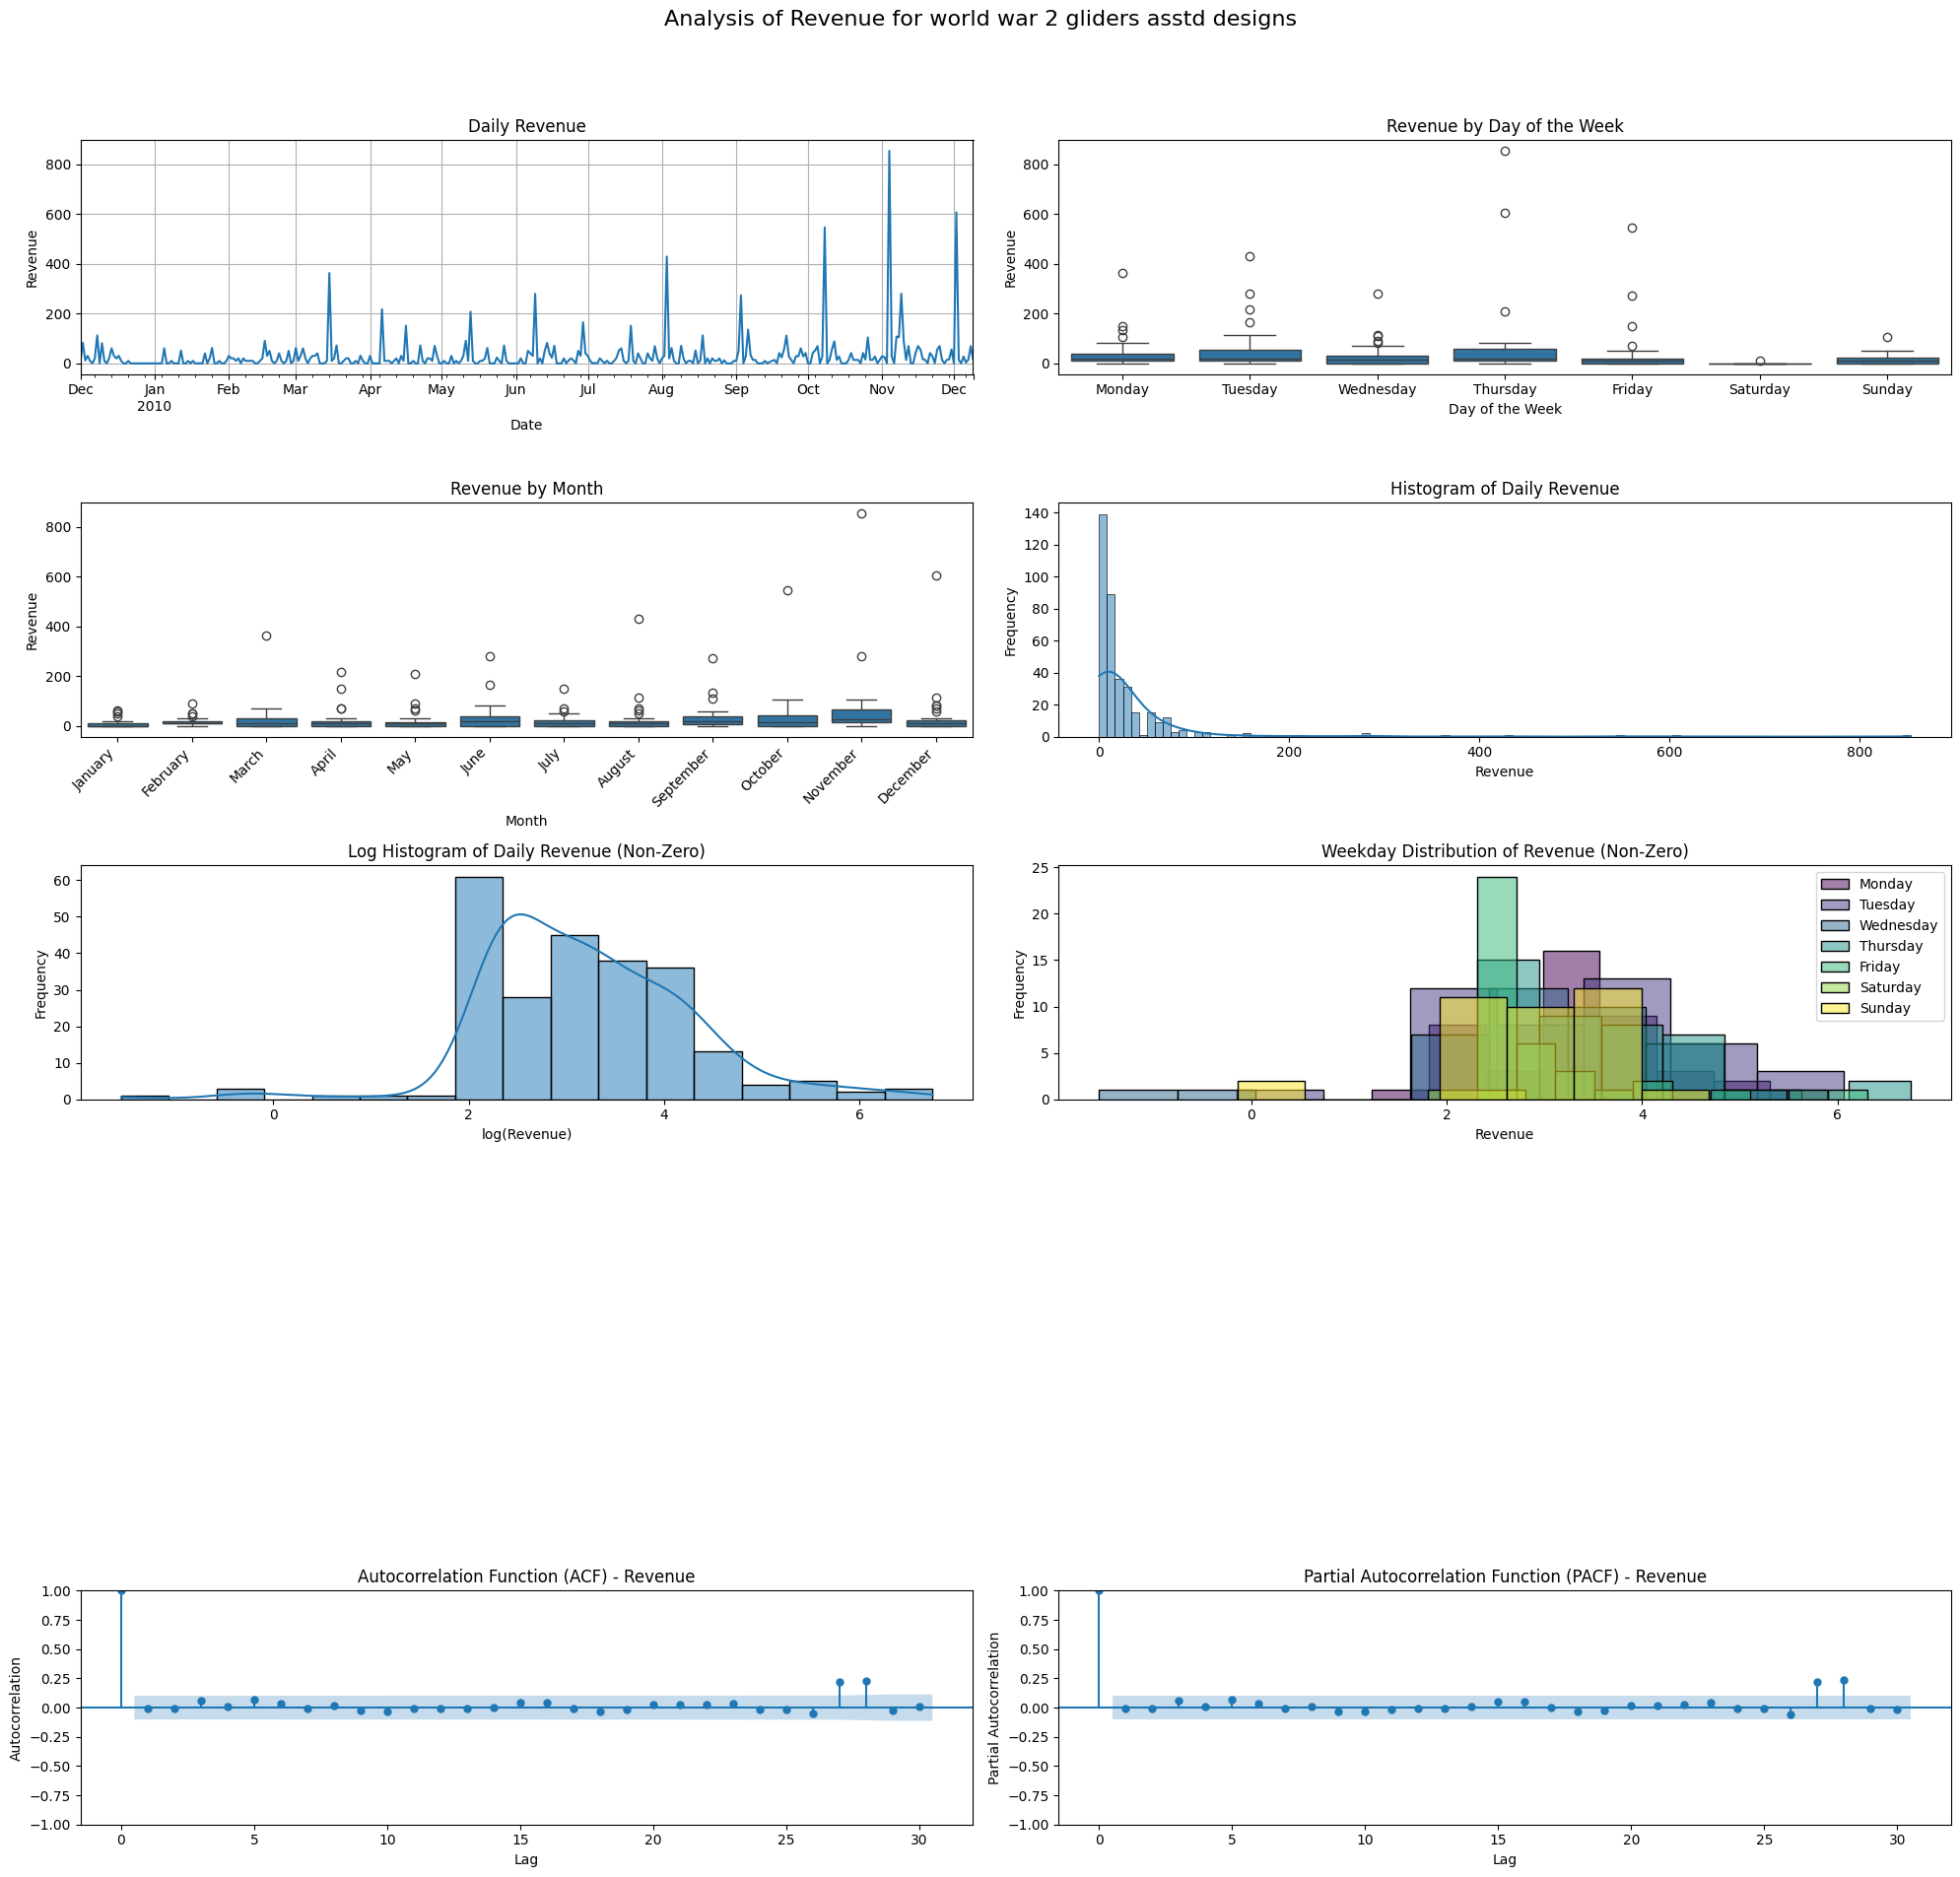

In [237]:
i = 2
visualize_product_series(pivoted_df['UnitsSold'][sample_products[i]], sample_products[i], 'UnitsSold')
visualize_product_series(pivoted_df['RevenuePounds'][sample_products[i]], sample_products[i], 'Revenue')

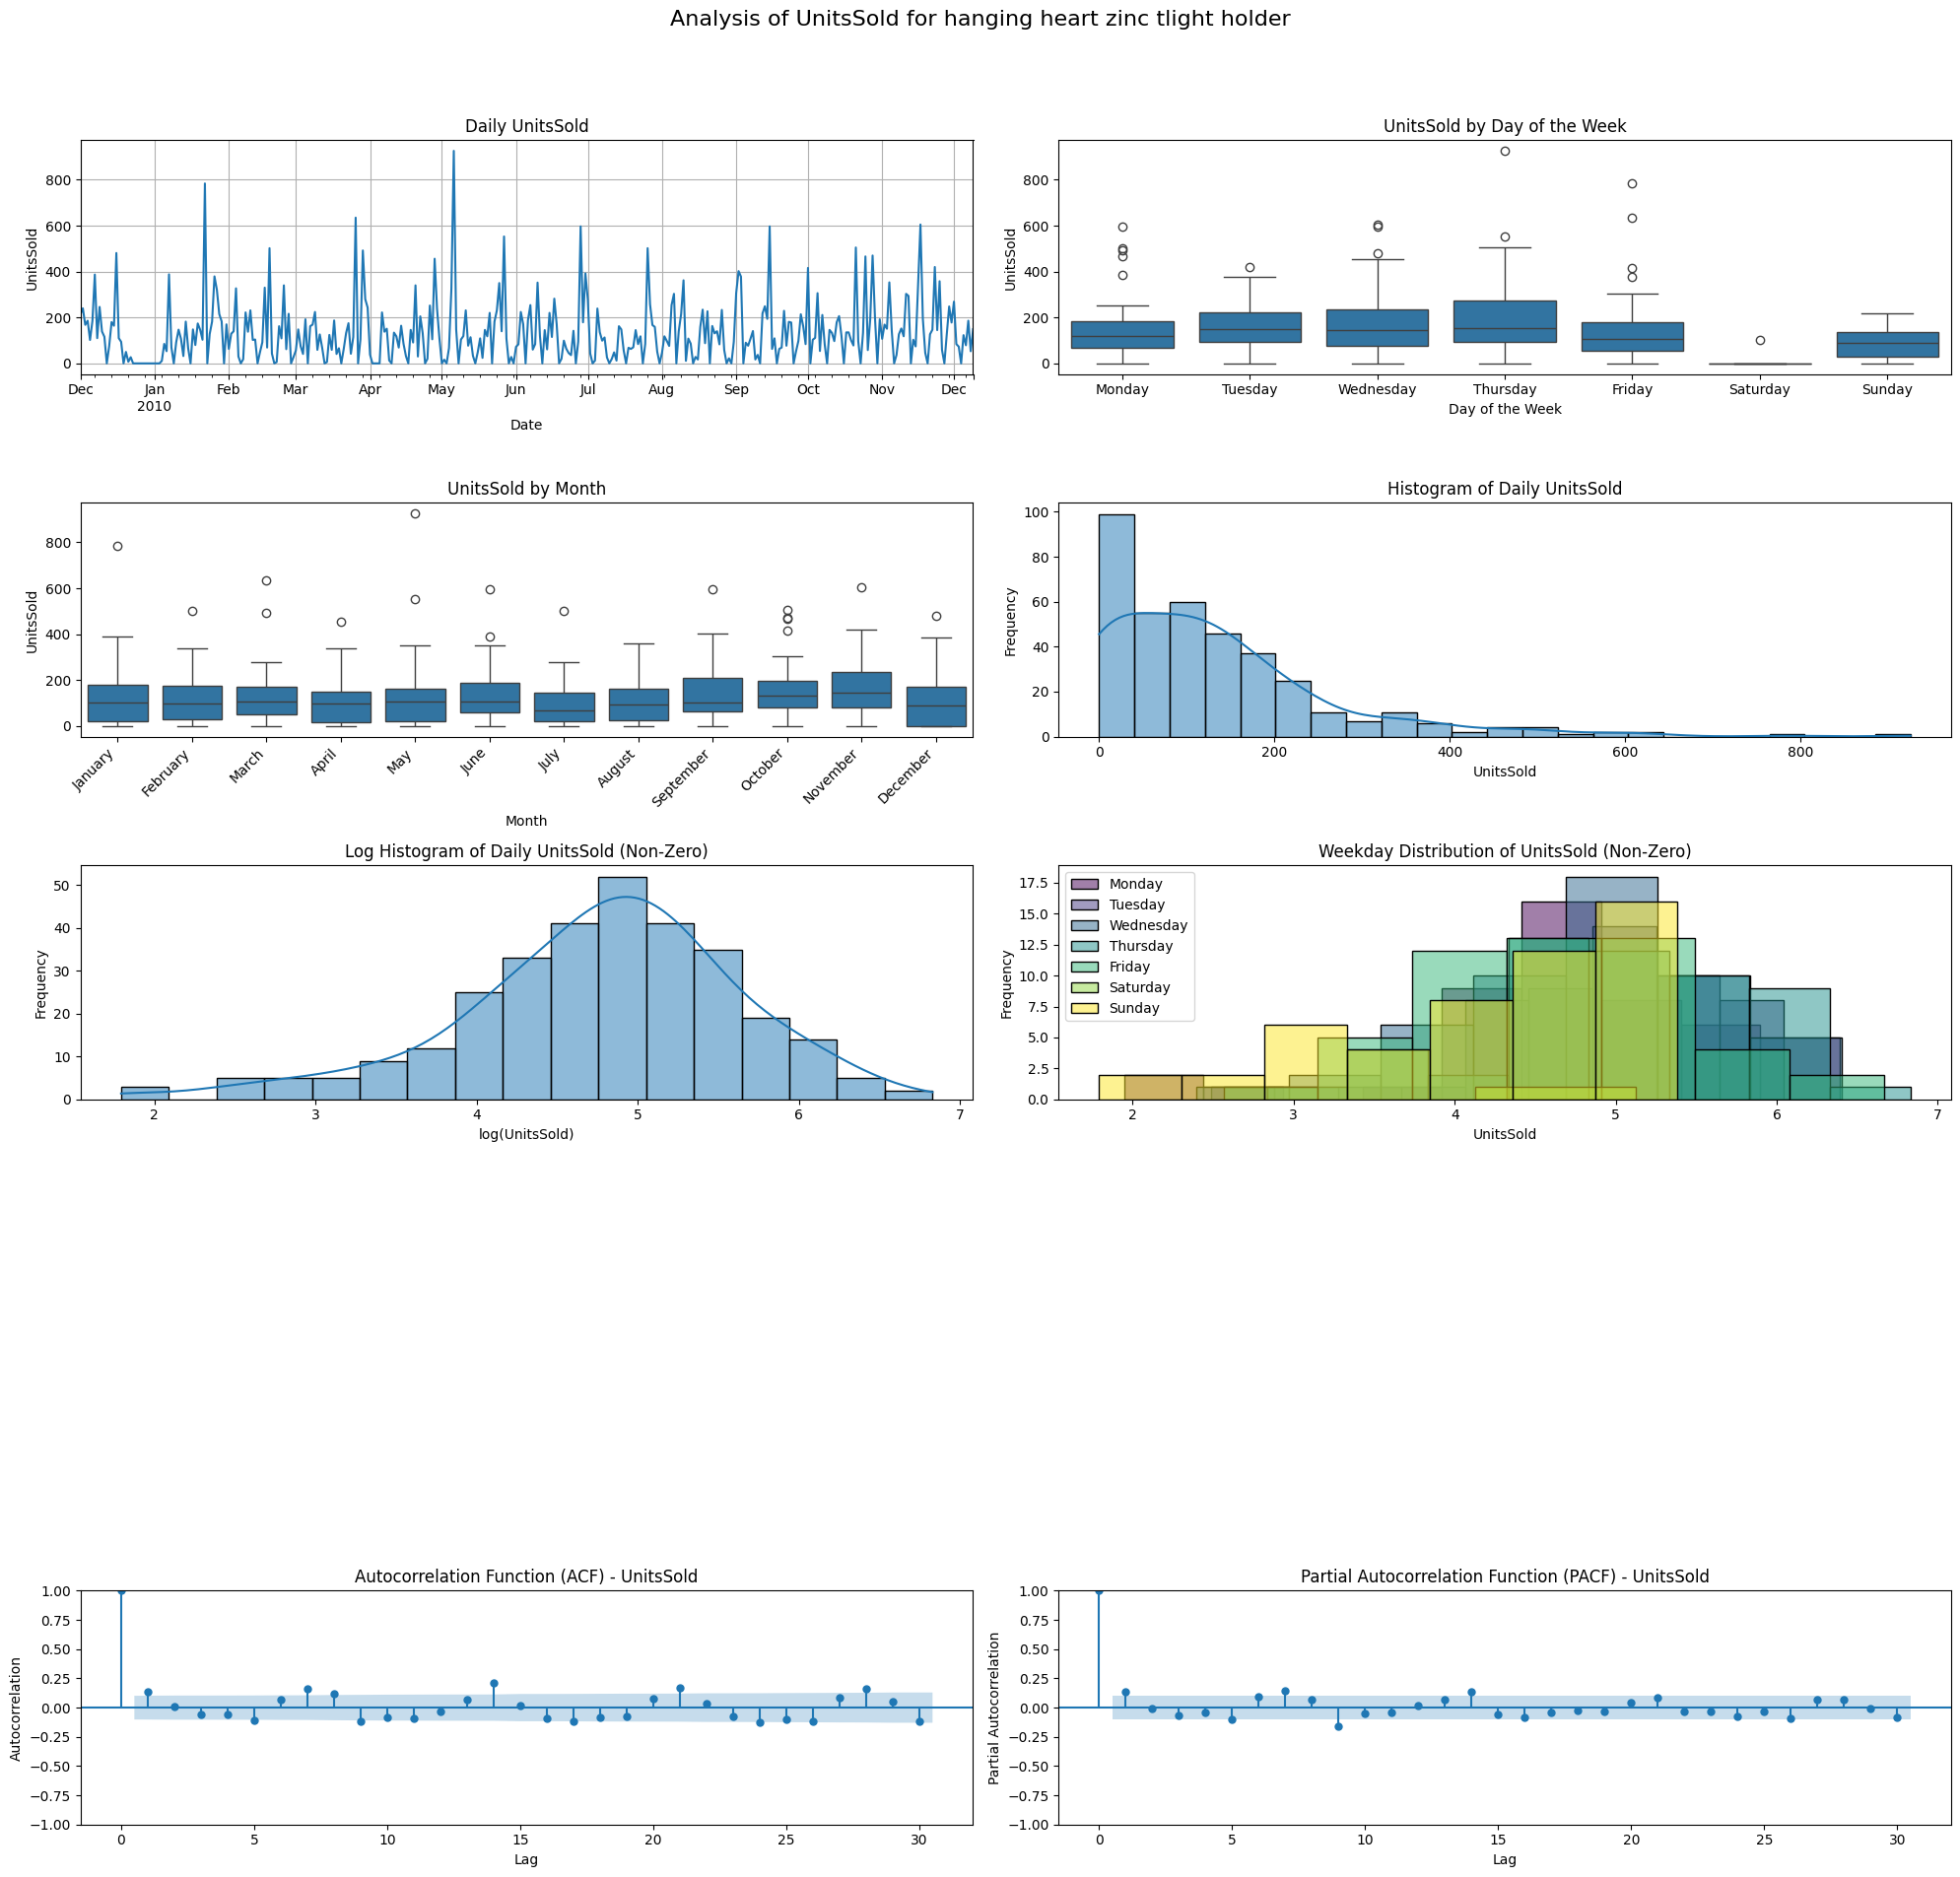

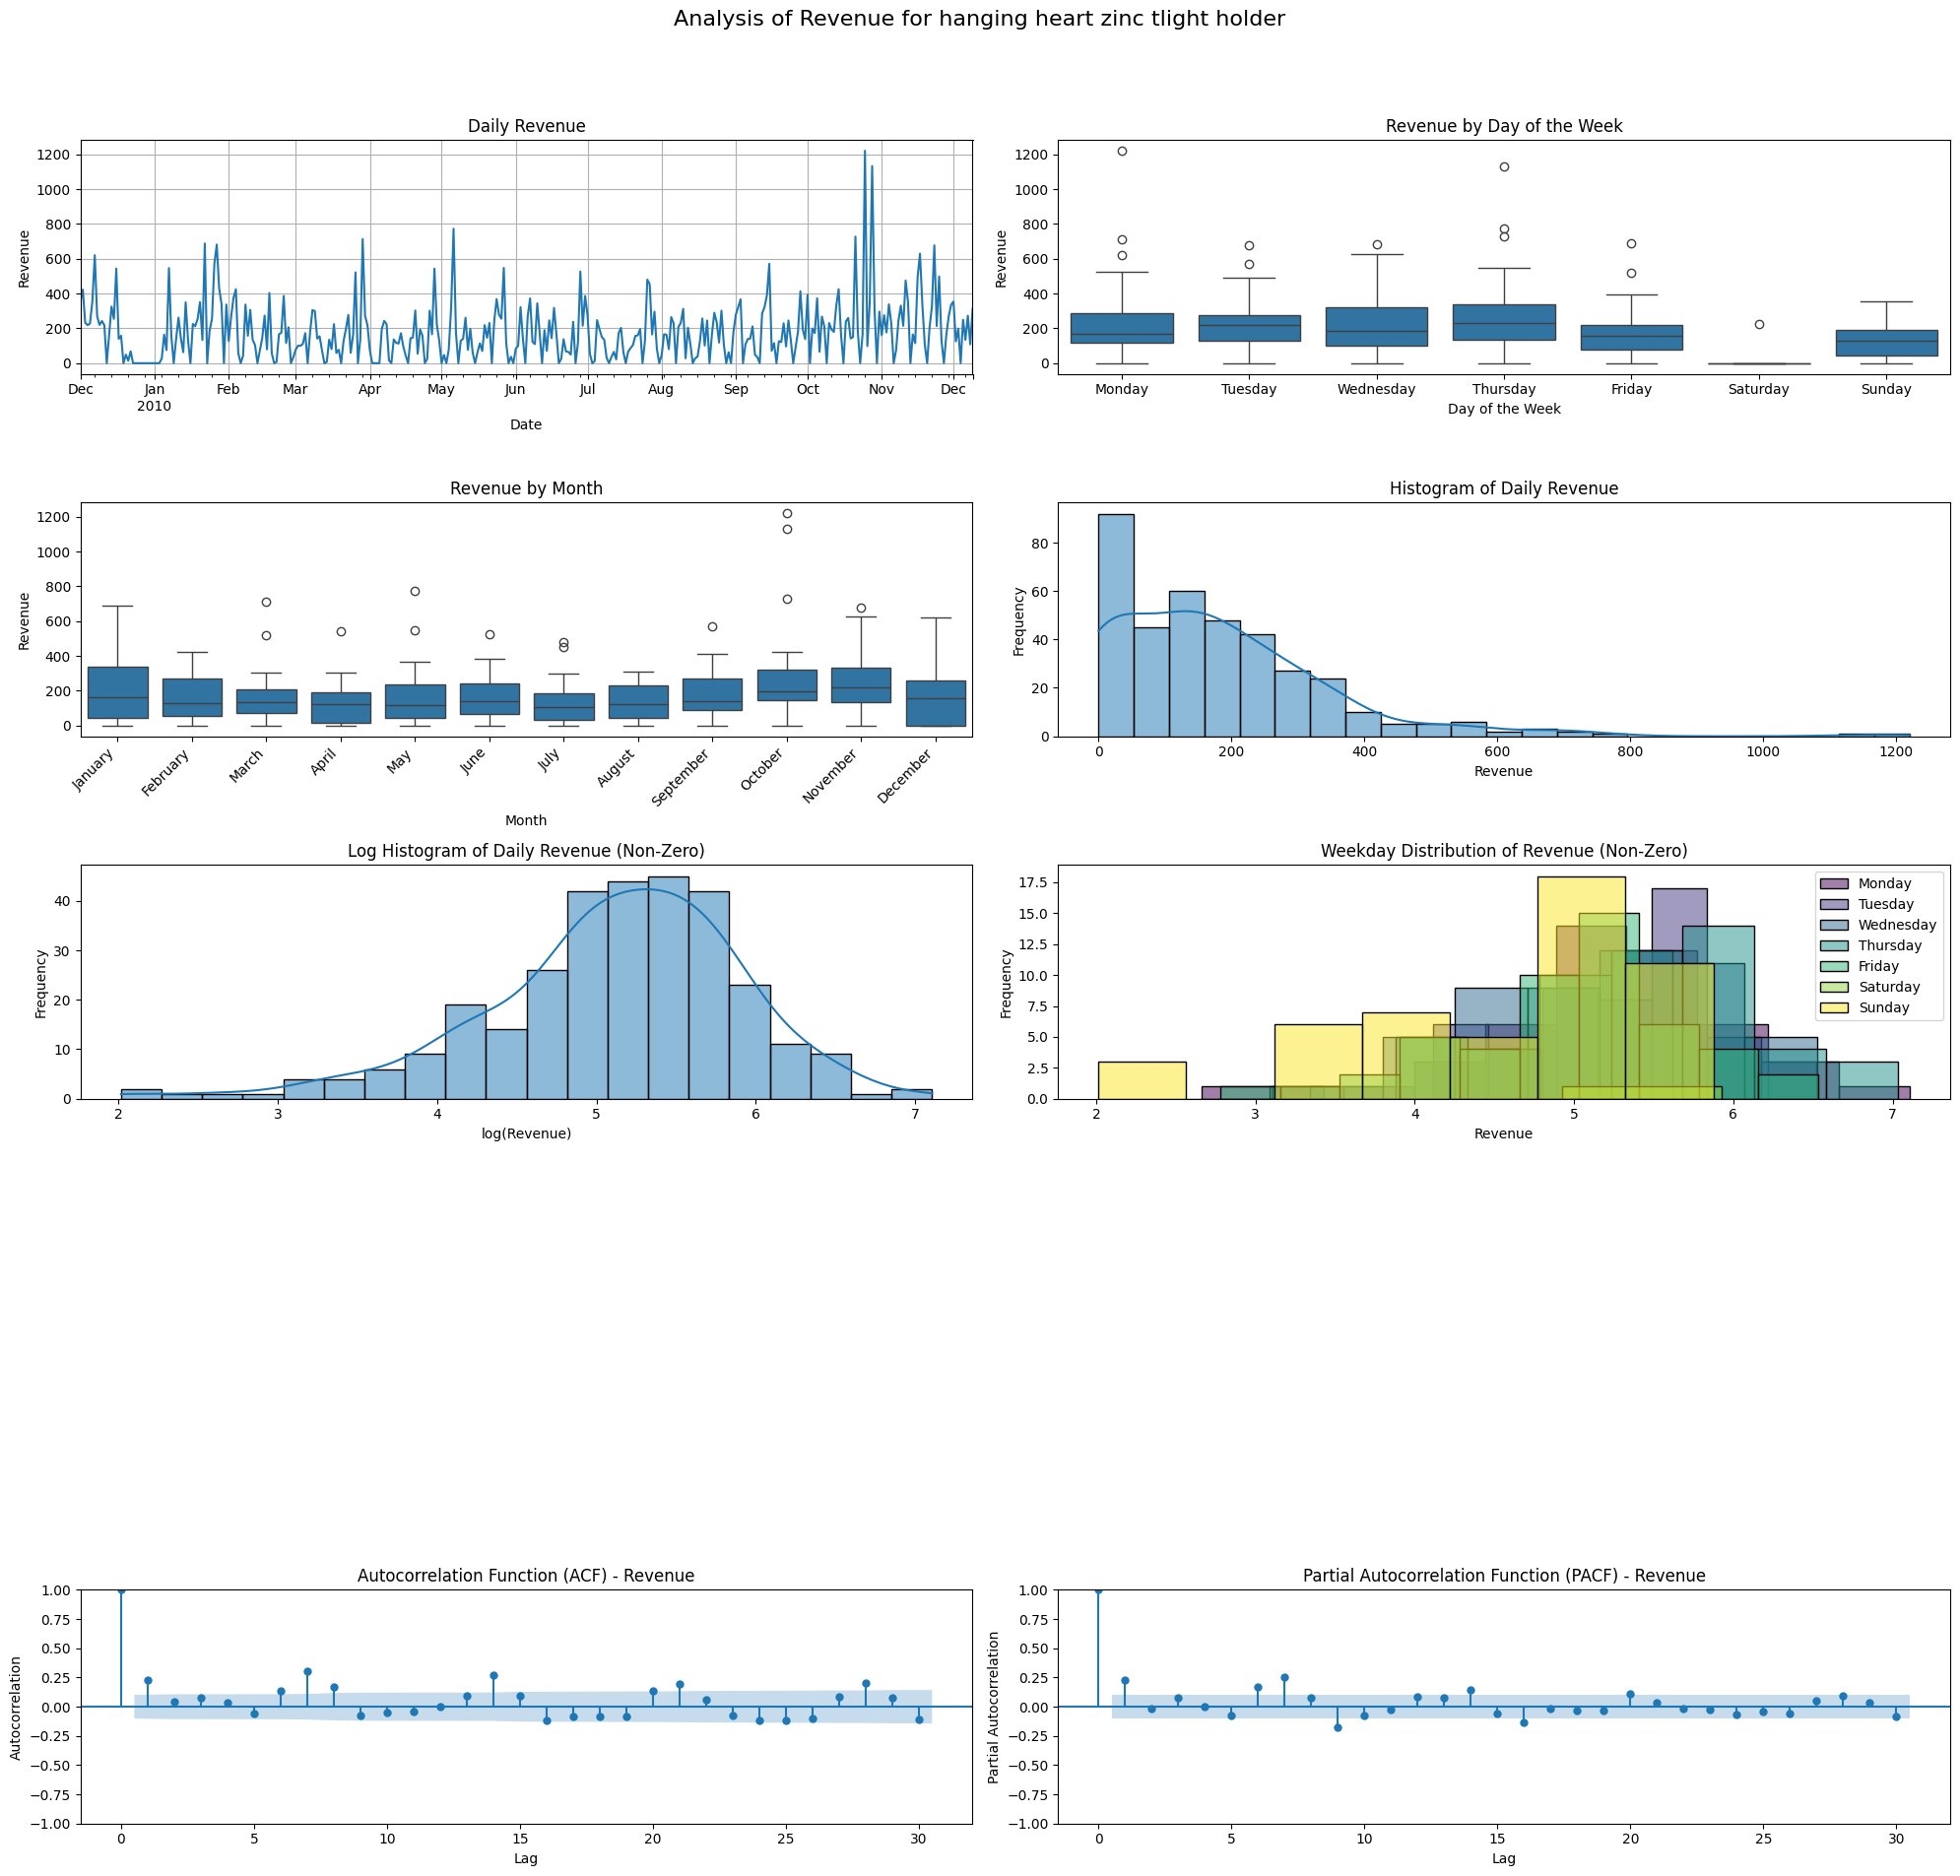

In [238]:
i = 3
visualize_product_series(pivoted_df['UnitsSold'][sample_products[i]], sample_products[i], 'UnitsSold')
visualize_product_series(pivoted_df['RevenuePounds'][sample_products[i]], sample_products[i], 'Revenue')

In [307]:
feature_dataset_df = online_retail_df[['Description', 'Date', 'UnitsSold', 'AveragePricePerUnitPounds', 'RevenuePounds']].copy()
feature_dataset_df['DayOfWeek_Str'] = feature_dataset_df['Date'].dt.day_name()

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

feature_dataset_df['DayOfWeek_CatOrdered'] = pd.Categorical(
    feature_dataset_df['DayOfWeek_Str'], categories=ordered_days, ordered=True
)

feature_dataset_df['DayOfWeek_Numerical'] = feature_dataset_df['DayOfWeek_CatOrdered'].cat.codes

day_of_week_dummies_ordered = pd.get_dummies(
    feature_dataset_df['DayOfWeek_CatOrdered'], dtype=int
)

feature_dataset_df = pd.concat([feature_dataset_df, day_of_week_dummies_ordered], axis=1)
feature_dataset_df = feature_dataset_df.drop(columns=[
    'DayOfWeek_Str',
    'DayOfWeek_CatOrdered',
])

feature_dataset_df['DayOfMonth'] = feature_dataset_df['Date'].dt.day

feature_dataset_df['DayBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(1)
feature_dataset_df['TwoDaysBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(2)
feature_dataset_df['WeekBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(7)
feature_dataset_df['MonthBefore'] = feature_dataset_df.groupby('Description')['UnitsSold'].shift(30)

feature_dataset_df = feature_dataset_df.fillna(0)

feature_dataset_df = feature_dataset_df.sort_values(by=['Description', 'Date'])

feature_dataset_df

,Description,Date,UnitsSold,AveragePricePerUnitPounds,RevenuePounds,DayOfWeek_Numerical,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,DayOfMonth,DayBefore,TwoDaysBefore,WeekBefore,MonthBefore
0,12 pencils small tube red spotty,2009-12-01,45,0.66,29.90,1,0,1,0,0,0,0,0,1,0.0,0.0,0.0,0.0
1,12 pencils small tube red spotty,2009-12-02,87,0.71,61.75,2,0,0,1,0,0,0,0,2,45.0,0.0,0.0,0.0
2,12 pencils small tube red spotty,2009-12-03,34,0.69,23.40,3,0,0,0,1,0,0,0,3,87.0,45.0,0.0,0.0
3,12 pencils small tube red spotty,2009-12-04,84,0.66,55.25,4,0,0,0,0,1,0,0,4,34.0,87.0,0.0,0.0
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.00,5,0,0,0,0,0,1,0,5,84.0,34.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53477,zinc metal heart decoration,2010-12-05,34,1.25,42.50,6,0,0,0,0,0,0,1,5,0.0,6.0,54.0,1.0
53478,zinc metal heart decoration,2010-12-06,33,1.52,50.07,0,1,0,0,0,0,0,0,6,34.0,0.0,82.0,0.0
53479,zinc metal heart decoration,2010-12-07,51,1.27,65.01,1,0,1,0,0,0,0,0,7,33.0,34.0,36.0,33.0
53480,zinc metal heart decoration,2010-12-08,20,1.31,26.26,2,0,0,1,0,0,0,0,8,51.0,33.0,27.0,81.0


In [308]:
last_date = feature_dataset_df['Date'].max() - timedelta(days=30)
train_df = feature_dataset_df[lambda x: x['Date'] <= last_date]
val_df = feature_dataset_df[lambda x: x['Date'] > last_date]

In [359]:
def train_trees(train_df: pd.DataFrame, features: list[str], target: str, criterion: str = 'squared_error'):
    products = train_df['Description'].unique()
    tree_models = dict()
    for product in products:
        product_train_df = train_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
        X_train, y_train = product_train_df[features], product_train_df[target]
        tree_models[product] = (
            DecisionTreeRegressor(random_state=42, criterion=criterion)
            .fit(X_train, y_train)
        )
    return tree_models

In [381]:
features = [
    'AveragePricePerUnitPounds',
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'DayOfMonth',
    'DayBefore', 'WeekBefore', 'MonthBefore',
]
target = 'UnitsSold'

tree_models = train_trees(train_df, features, target)

In [402]:
def get_autoregressive_predictions(
    tree_model: DecisionTreeRegressor,
    prev_values: pd.Series,
    known_future_prices_per_unit: pd.Series,
):
    """
    Performs an autogressive forecast using the tree.

    Args:
        tree_model: A trained DecisionTreeRegressor.
        prev_values: A Pandas series containing all known previous unit sales. The index
            should be the date.
        known_future_prices_per_unit: A Pandas series with the known price of the good
            during the dates to forecast. Should have dates as index.
    Returns:
        A series representing the predictions for the next number of days.
    """
    values = prev_values.sort_index()
    known_future_prices_per_unit = known_future_prices_per_unit.sort_index()
    for date in known_future_prices_per_unit.index:
        price = known_future_prices_per_unit.loc[date]
        
        is_monday = date.dayofweek == 0
        is_tuesday = date.dayofweek == 1
        is_wednesday = date.dayofweek == 2
        is_thursday = date.dayofweek == 3
        is_friday = date.dayofweek == 4
        is_saturday = date.dayofweek == 5
        is_sunday = date.dayofweek == 6

        day_of_month = date.day
        
        prev_day = values.loc[date - timedelta(days=1)]
        prev_week = values.loc[date - timedelta(days=7)]
        prev_month = values.loc[date - timedelta(days=30)]
        
        X = np.array([[
            price,
            is_monday,
            is_tuesday,
            is_wednesday,
            is_thursday,
            is_friday,
            is_saturday,
            is_sunday,
            day_of_month,
            prev_day,
            prev_week,
            prev_month
        ]])
        pred = round(tree_model.predict(X)[0])
        values[date] = pred
    return values.loc[known_future_prices_per_unit.index]
        
def get_predictions_for_product(tree_model, all_values, known_future_prices_per_unit, forecast_len = 7):
    all_values = all_values.sort_index()
    known_future_prices_per_unit = known_future_prices_per_unit.sort_index()
    predictions_df = pd.DataFrame(columns=range(1, forecast_len + 1), index=product_val_df.index)
    for date in known_future_prices_per_unit.index:
        end_date = date+timedelta(days=forecast_len)
        preds = get_autoregressive_predictions(
            tree_model,
            all_values.loc[:date],
            known_future_prices_per_unit.loc[date:end_date],
        )
        np.fill_diagonal(predictions_df.loc[date:end_date,:len(preds)].values, preds)
    return predictions_df


# def evaluate_trees(
#     train_df: pd.DataFrame,
#     val_df: pd.DataFrame,
#     tree_models: dict[str, DecisionTreeRegressor],
#     features: list[str],
#     target: str,
#     forecast_len: int = 7
# ):
#     products = val_df['Description'].unique()
#     for product in products:
#         product_val_df = val_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
#         X, y = product_val_df[features], product_val_df[target]
#         tree_model = tree_models[product]
#         for next_date in product_val_df.index:
#             X_context = X.loc[next_date:next_date + timedelta(days=forecast_len)]
#             for offset in range(forecast_len):
                

<Axes: xlabel='Date'>

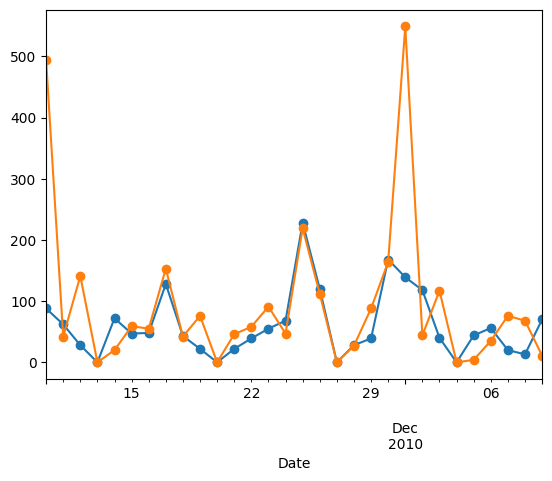

In [429]:
product = sample_products[8]
product

product_train_df = train_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
product_val_df = val_df[lambda x: x['Description'] == product].set_index('Date').sort_index()

all_values = pd.concat([product_train_df['UnitsSold'], product_val_df['UnitsSold']], axis=0).sort_index()
known_future_prices_per_unit = product_val_df['AveragePricePerUnitPounds'].sort_index()

get_predictions_for_product(tree_models[product], all_values, known_future_prices_per_unit)[1].plot(marker='o')
product_val_df['UnitsSold'].plot(marker='o')

<Axes: xlabel='Date'>

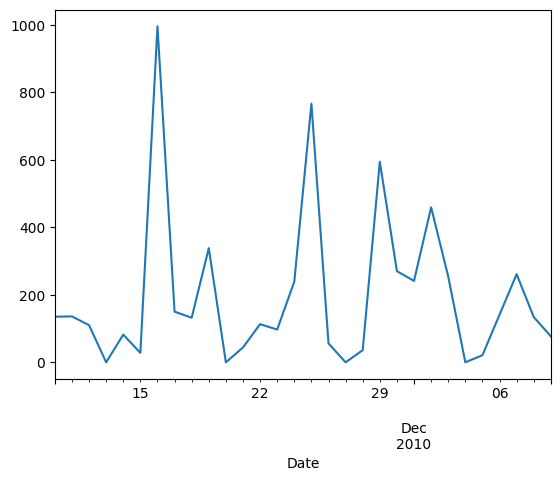

In [406]:
product_val_df['UnitsSold'].plot()

<Axes: xlabel='Date'>

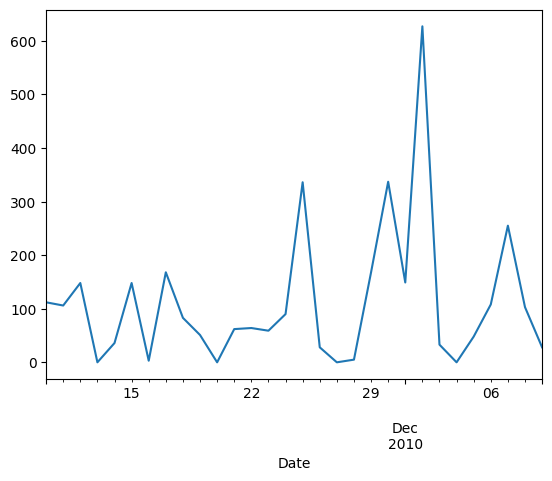

In [390]:
product_train_df = train_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
product_val_df = val_df[lambda x: x['Description'] == product].set_index('Date').sort_index()

get_autoregressive_predictions(tree_models[product], product_train_df['UnitsSold'], product_val_df['AveragePricePerUnitPounds']).plot()

In [392]:
product_train_df['UnitsSold'].loc[:'2009-12-02']

Date
2009-12-01    312
2009-12-02    599
Name: UnitsSold, dtype: int64

In [369]:
product_val_df['AveragePricePerUnitPounds']

Date
2010-11-10    0.58
2010-11-11    0.56
2010-11-12    0.96
2010-11-13    0.00
2010-11-14    0.55
2010-11-15    0.97
2010-11-16    0.55
2010-11-17    0.46
2010-11-18    0.59
2010-11-19    0.67
2010-11-20    0.00
2010-11-21    0.55
2010-11-22    0.61
2010-11-23    0.56
2010-11-24    0.76
2010-11-25    0.45
2010-11-26    0.66
2010-11-27    0.00
2010-11-28    0.55
2010-11-29    0.46
2010-11-30    0.88
2010-12-01    0.55
2010-12-02    0.45
2010-12-03    1.01
2010-12-04    0.00
2010-12-05    0.55
2010-12-06    0.55
2010-12-07    1.19
2010-12-08    0.59
2010-12-09    0.66
Name: AveragePricePerUnitPounds, dtype: float64

In [358]:
evaluate_trees(train_df, val_df, tree_models, features, target)

            AveragePricePerUnitPounds  Monday  Tuesday  Wednesday  Thursday  \
Date                                                                          
2010-11-10                       0.84       0        0          1         0   
2010-11-11                       0.66       0        0          0         1   
2010-11-12                       0.78       0        0          0         0   
2010-11-13                       0.00       0        0          0         0   
2010-11-14                       0.67       0        0          0         0   
2010-11-15                       0.82       1        0          0         0   
2010-11-16                       0.75       0        1          0         0   
2010-11-17                       0.66       0        0          1         0   

            Friday  Saturday  Sunday  DayOfMonth  DayBefore  WeekBefore  \
Date                                                                      
2010-11-10       0         0       0          10       43.0

In [365]:
product = sample_products[0]
product

'pack of 72 retro spot cake cases'

In [338]:
product_train_df = train_df[lambda x: x['Description'] == product].set_index('Date').sort_index()
product_val_df = val_df[lambda x: x['Description'] == product].set_index('Date').sort_index()

features = [
    'AveragePricePerUnitPounds',
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'DayOfMonth', 'DayBefore', 'WeekBefore', 'MonthBefore',
]
target = 'UnitsSold'

X_train, y_train = product_train_df[features], product_train_df[target]
X_val, y_val = product_val_df[features], product_val_df[target]

In [340]:
X_val.index

DatetimeIndex(['2010-11-10', '2010-11-11', '2010-11-12', '2010-11-13',
               '2010-11-14', '2010-11-15', '2010-11-16', '2010-11-17',
               '2010-11-18', '2010-11-19', '2010-11-20', '2010-11-21',
               '2010-11-22', '2010-11-23', '2010-11-24', '2010-11-25',
               '2010-11-26', '2010-11-27', '2010-11-28', '2010-11-29',
               '2010-11-30', '2010-12-01', '2010-12-02', '2010-12-03',
               '2010-12-04', '2010-12-05', '2010-12-06', '2010-12-07',
               '2010-12-08', '2010-12-09'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [314]:
tree_model = DecisionTreeRegressor(random_state=42)

tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

np.float64(0.5250420267994521)

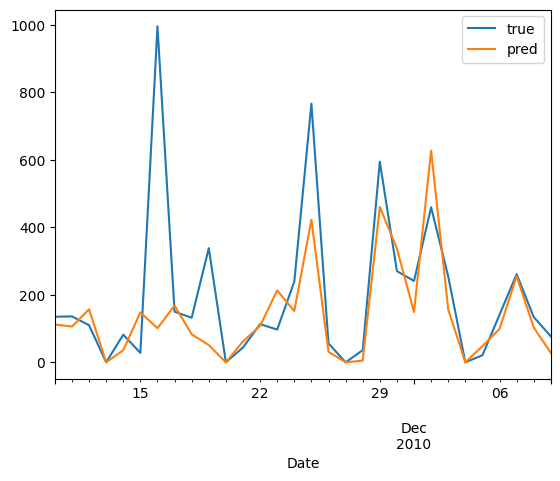

In [315]:
y_val_pred = tree_model.predict(X_val)

predictions_df = pd.DataFrame(data={
    'true': y_val.values,
    'pred': y_val_pred,
}, index=y_val.index)

numerator = np.abs(predictions_df['true'] - predictions_df['pred'])
denominator = predictions_df['true']

both_zero = (numerator == 0) & (denominator == 0)

predictions_df['mae'] = np.where(both_zero, 0, numerator / denominator)

predictions_df[['true', 'pred']].plot()

predictions_df['mae'].mean()

np.float64(inf)

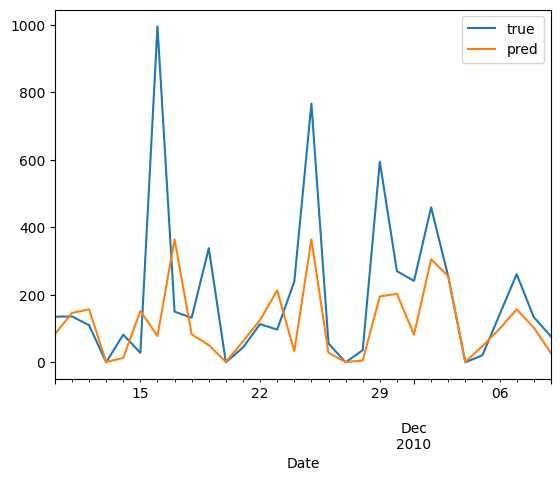

In [325]:
y_val_pred = tree_models[product].predict(X_val)

predictions_df = pd.DataFrame(data={
    'true': y_val.values,
    'pred': y_val_pred,
}, index=y_val.index)

numerator = np.abs(predictions_df['true'] - predictions_df['pred'])
denominator = predictions_df['true']

both_zero = (numerator == 0) & (denominator == 0)

predictions_df['mae'] = np.where(both_zero, 0, numerator / denominator)

predictions_df[['true', 'pred']].plot()

predictions_df['mae'].mean()

In [326]:
y_val_pred

array([ 83.        , 146.        , 157.        ,   0.97959184,
        13.        , 152.        ,  78.        , 364.        ,
        83.        ,  51.        ,   0.97959184,  62.        ,
       125.        , 213.        ,  33.        , 364.        ,
        28.        ,   0.97959184,   5.        , 195.        ,
       203.        ,  82.        , 305.        , 255.        ,
         0.97959184,  48.        ,  99.        , 157.        ,
       103.        ,  28.        ])

In [327]:
y_val

Date
2010-11-10    135
2010-11-11    136
2010-11-12    110
2010-11-13      0
2010-11-14     82
2010-11-15     28
2010-11-16    995
2010-11-17    150
2010-11-18    132
2010-11-19    338
2010-11-20      0
2010-11-21     44
2010-11-22    113
2010-11-23     97
2010-11-24    239
2010-11-25    766
2010-11-26     56
2010-11-27      0
2010-11-28     36
2010-11-29    594
2010-11-30    270
2010-12-01    241
2010-12-02    459
2010-12-03    254
2010-12-04      0
2010-12-05     21
2010-12-06    141
2010-12-07    261
2010-12-08    134
2010-12-09     77
Name: UnitsSold, dtype: int64

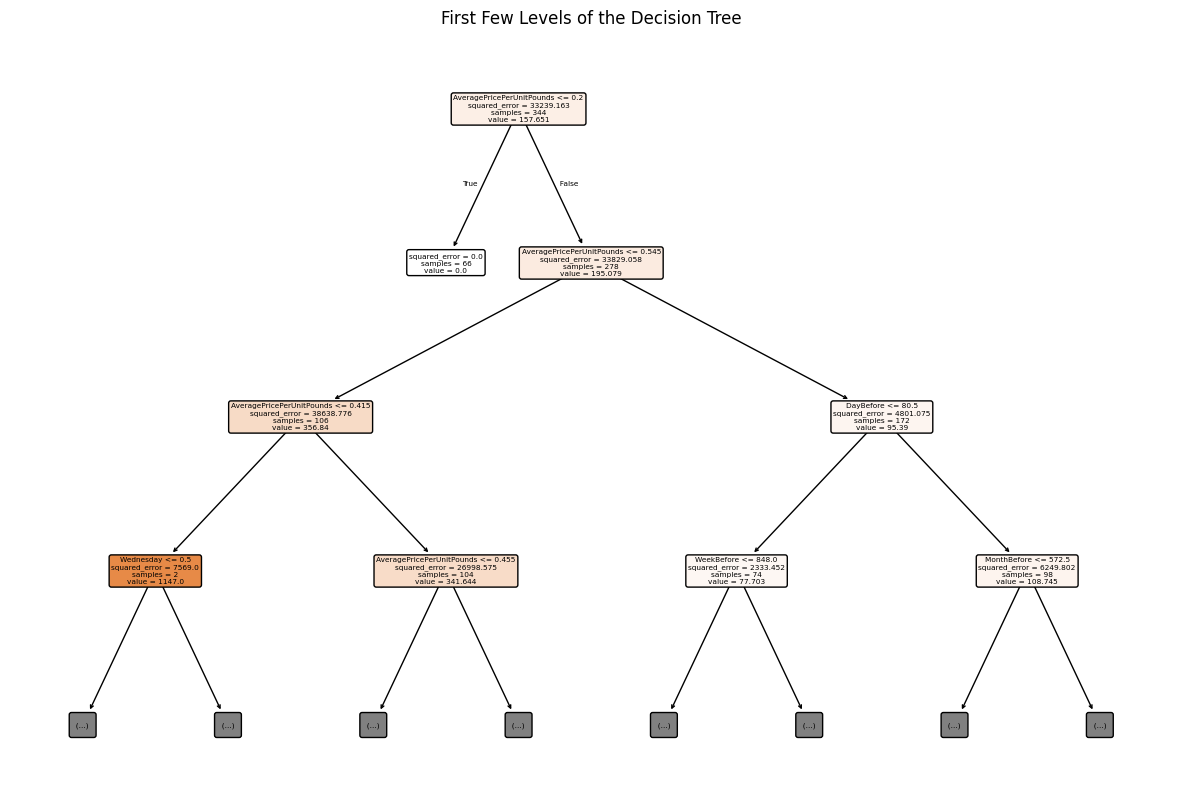

In [316]:
plt.figure(figsize=(15, 10))
plot_tree(tree_model,
          feature_names=features, # Your list of feature names
          filled=True,
          rounded=True,
          max_depth=3) # Adjust max_depth to show more or fewer levels
plt.title('First Few Levels of the Decision Tree')
plt.show()

In [299]:
tree_model.feature_importances_

array([7.37192441e-01, 1.65977625e-04, 1.44226547e-02, 7.05109790e-03,
       2.29751797e-03, 2.68775169e-03, 1.39591308e-04, 2.39198556e-03,
       4.61651459e-02, 5.26416830e-02, 8.02579212e-02, 5.45862323e-02])

In [300]:
features

['AveragePricePerUnitPounds',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday',
 'DayOfMonth',
 'DayBefore',
 'WeekBefore',
 'MonthBefore']

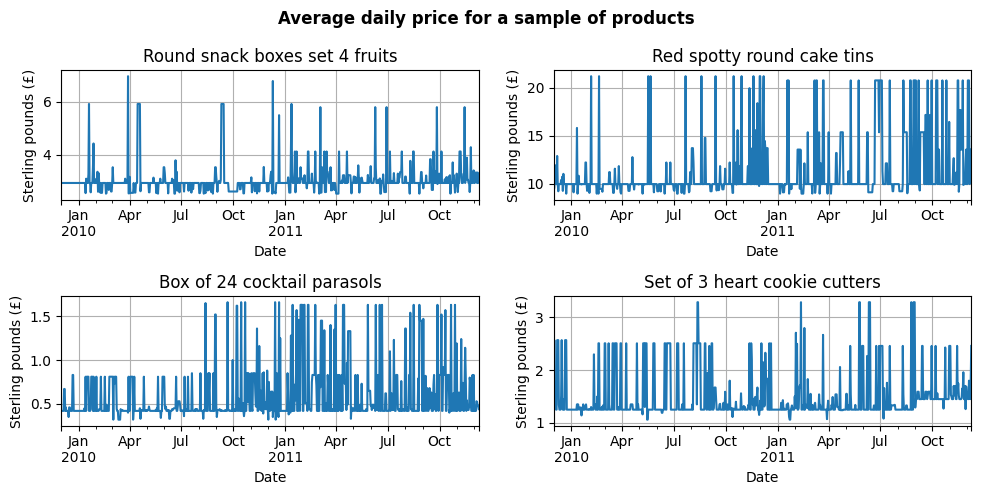

In [7]:
prices_df = online_retail_df.pivot(index='Date', columns='Description', values='AveragePricePerUnitPounds')

product_sample = np.random.choice(prices_df.columns, size=4)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,5))

fig.suptitle('Average daily price for a sample of products', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    prices_df[product].plot(ax=ax)

    ax.set_title(product.capitalize())
    ax.set_xlabel('Date')
    ax.set_ylabel('Sterling pounds (£)')
    ax.grid()

plt.tight_layout()
plt.show()